In [1]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools

In [2]:
#Currently working with a small tracking cost. Will implement the cost to go constraint now. 

In [3]:
#Fixes to try: 
#1. Get discrete dynamics jacobians with RK4. Matrix exponential is only exact for LTI systems. (done)
#2. Implement the second order correction (done) (not needed, it was a bug with the reference trajectory)
#3. More conservative half space constraint (done)
#4. Change the c at each knot point according to the maximum delta x deviation possible

#4. Current orbit is not exactly periodic (xend - xinitial). Set the reference trajectory to that orbit revd twice instead of concatenating two arrays (potential fix)

In [4]:
#Current bug: reference_trajectory2 has to be updated in the half solve. Currently it is the wrong dynamics constraint since the reference trajectory is
# from the beginning.  

In [5]:
# #scaled dynamics in the user defined custom units  
# function threebp_dynamics_scaled(x, u)
    
#     q_original = zeros(eltype(x),3)
#     v_original = zeros(eltype(x),3)
#     q_original = x[1:3]*custom_position_scale 
#     v_original = x[4:6]*custom_velocity_scale
    
#     x_original = [q_original; v_original]
    
#     if Lagrange_Point == "L1"
        
#         #L1 Lagrange Point for Earth Moon System (from the lagrange file)
#         L = [0.8369180073169304, 0,0,0,0,0]

#     else
        
#         #L2 Lagrange Point for Earth Moon System (from the lagrange file)
#         L = [1.1556799130947355,0,0,0,0,0]

#     end
    
#     #get it back to original units and without the L1 shift  
#     x_original_unshift = x_original+L
    
#     ẋ_original = zeros(eltype(x),6)
    
#     #calculate the original xdot (no scaling)
#     ẋ_original = threebp_dynamics(x_original_unshift, u)

#     #then scale these dynamics
#     v_scaled = ẋ_original[1:3]/custom_velocity_scale
    
#     a_scaled = ẋ_original[4:6]/custom_accel_scale
        
#     ẋ_scaled = [v_scaled; a_scaled]

#     return ẋ_scaled
# end

In [6]:
#from the Lyaponov orbit
#x0_lyapunov = [ 1.1556814491008298,
# -1.4319993886822296e-21,
#  0.0,
#  2.2212106056655213e-21,
# -8.333136405918907e-6,
#  0.0]



 #lyapunov_period = 3.3732524857835884


In [7]:
# T_og = 2.361e6 #in seconds - orbital period of m1 and m2
# time_scale_og = T_og/(2*pi)

In [8]:
og_time_scale = 2.361e6/(2*pi)

375764.8206399649

In [9]:
#parameters for Earth Moon System
μ = 1.215e-2
μ1 = 1-μ
μ2 = μ

#position of mass 1
pose_m1 = [-μ, 0, 0]

#position of mass 2
pose_m2 = [1-μ, 0, 0]

#value obtained from 3BP textbook (original)
L = 3.850e5 #in km - distance between centers of m1 and m2
#V_ = 1.025 #in km/s - orbital velocity of m1
#T_ = 2.361e6 #in seconds - orbital period of m1 and m2


#working
#########################################################################################
#updated for time unit to be in days
T_ = 2.361e6/86400 #in days - orbital period of m1 and m2
time_scale = T_/(2*pi)

#time unit of days
V_ = L/time_scale
acceleration_scale = L/((time_scale)^2)
##########################################################################################

#state of the L1 and L2 Lagrange points (computed offline)
XL1 = [0.8369180073169304, 0, 0, 0, 0, 0]
XL2 = [1.1556799130947355, 0, 0, 0, 0, 0]

6-element Vector{Float64}:
 1.1556799130947355
 0.0
 0.0
 0.0
 0.0
 0.0

In [11]:
acceleration_scale

20354.29089708545

In [12]:
time_scale

4.349129868518112

In [13]:
V_

88523.45449302066

In [14]:
function effective_potential(X)
    x = X[1]
    y = X[2]
    z = X[3]

    r1 = sqrt((x+μ2)^2 + y^2 + z^2) 
    r2 = sqrt((x-μ1)^2 + y^2 + z^2)
    #assuming m3 is unit mass
   
    U = (-μ1/r1)-(μ2/r2)-0.5*(x^2+y^2)
   
    return U
    
end

effective_potential (generic function with 1 method)

In [15]:
function three_body_prob_dynamics(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]

    ẋ = zeros(eltype(x),6)
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] 
    ẋ[5] = -2*v[1] - U_q[2]
    ẋ[6] = -U_q[3]

    return ẋ
end

three_body_prob_dynamics (generic function with 1 method)

In [16]:
#x[1:6] -> state
#x[7:9] -> control inputs

#coming in with SI units
function three_body_prob_dynamics_wcontrol(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]
    u = x[7:9]

    ẋ = zeros(eltype(x),9)
    
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] + u[1] 
    ẋ[5] = -2*v[1] - U_q[2] + u[2]
    ẋ[6] = -U_q[3] + u[3]
    
    #zero order hold on the controls 
    ẋ[7:9] = zeros(3)

    return ẋ
end

three_body_prob_dynamics_wcontrol (generic function with 1 method)

In [17]:
#this just scales the dynamics by L and V_

In [18]:
#inputs are in the custom SI unit scale

function three_body_prob_dynamics_scaled(x)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    
    x_original = [q_original; v_original]

    #original is in the CR3BP units
    ẋ_original = zeros(eltype(x),6)

    #calculate the original xdot (no scaling)

    ẋ_original = three_body_prob_dynamics(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_scaled (generic function with 1 method)

In [19]:
#inputs are in the custom scaled units

function three_body_prob_dynamics_wcontrol_scaled(x)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    u_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    u_original = x[7:9]/acceleration_scale
    
    x_original = [q_original; v_original; u_original]

    ẋ_original = zeros(eltype(x),9)

    #calculate the original xdot (no scaling)

    #xoriginal is in the CR3BP units
    ẋ_original = three_body_prob_dynamics_wcontrol(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    u_scaled = ẋ_original[7:9]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled; u_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_wcontrol_scaled (generic function with 1 method)

In [20]:
#this shifts the origin to L2 and scales by custom scales

In [21]:
# #inputs are in the custom scaled units

# function three_body_dynamics_scaled(x)

#     q_original = zeros(eltype(x),3)
#     v_original = zeros(eltype(x),3)
    
#     q_original = x[1:3]*custom_position_scale 
#     v_original = x[4:6]*custom_velocity_scale
    
#     x_original = [q_original; v_original]

#     #get it back to original units and without the L2 shift  
#     x_original_unshift = x_original+ XL2

#     ẋ_original = zeros(eltype(x),6)

#     #calculate the original xdot (no scaling)

#     ẋ_original = three_body_prob_dynamics(x_original_unshift)

#     #then scale the output
#     v_scaled = ẋ_original[1:3]/custom_velocity_scale
    
#     a_scaled = ẋ_original[4:6]/custom_accel_scale

#     ẋ_scaled = [v_scaled; a_scaled]

#     return ẋ_scaled

# end

In [22]:
# #inputs are in the custom scaled units

# function three_body_dynamics_wcontrol_scaled(x)

#     q_original = zeros(eltype(x),3)
#     v_original = zeros(eltype(x),3)
#     u_original = zeros(eltype(x),3)
    
#     q_original = x[1:3]*custom_position_scale 
#     v_original = x[4:6]*custom_velocity_scale
#     u_original = x[7:9]*custom_acceleration_scale
    
#     x_original = [q_original; v_original]

#     #get it back to original units and without the L2 shift  
#     x_original_unshift = x_original+ XL2

#     ẋ_original = zeros(eltype(x),9)

#     #x in regular units
#     x_reg = [x_original_unshift; u_original]

#     #calculate the original xdot (no scaling)

#     ẋ_original = three_body_prob_dynamics_wcontrol(x_reg)

#     #then scale the output
#     v_scaled = ẋ_original[1:3]/custom_velocity_scale
    
#     a_scaled = ẋ_original[4:6]/custom_accel_scale

#     u_scaled = ẋ_original[7:9]/custom_accel_scale

#     ẋ_scaled = [v_scaled; a_scaled; u_scaled]

#     return ẋ_scaled

# end

In [23]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL_wcontrol!(du, u, p, t)
    
    #original CR3BP units
    #du[1:9] = three_body_prob_dynamics_wcontrol(u[1:9])

    #scaled units
    du[1:9] = three_body_prob_dynamics_wcontrol_scaled(u[1:9])
    
end

ST_and_dynamics_DFJL_wcontrol! (generic function with 1 method)

In [24]:
#ensure that the x_0 coming in and the period are in scaled units

function dynamics_wcontrol_integrate(x_0,period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL_wcontrol!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

dynamics_wcontrol_integrate (generic function with 1 method)

In [25]:
#input is the initial condition
#control trajectory u (size N-1)

#integrate every half orbit

#u is size 20

#40 knot points in one rev. each of them are equally spaced apart


#ensure everything is in scaled units
function integrate_halfperiod(x_0, u)
    
    #u will be size 20
    
    #x trajectory not delta x 

    xtraj = zeros(6, 21)

    xtraj[:,1] = x_0

    #go through all the controls
    for i=1:20
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        #has the scaling included
        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)

        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
        
    end
    
    #this is size N. 21. Element 21 is the new 1
    return xtraj
        
end

integrate_halfperiod (generic function with 1 method)

In [26]:
function integrate_oneperiod(x_0, u)
    
    #u will be size 40 since we only want to apply the controls for one rev
    
    #x trajectory not delta x 

    xtraj = zeros(6, N_period)

    xtraj[:,1] = x_0

    for i=1:N_period-1
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)
        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
    end
    
    #this is size N. 40 for this case
    return xtraj
        
end

integrate_oneperiod (generic function with 1 method)

In [27]:
#ODE for the state transition matrix 

function phi_ode(z)
    
    #state vector
    x = z[1:6]
    
    #state transition matrix
    Φ = reshape(z[7:end], (6,6))
    
    #Find the dynamics jacobian at the state vector (CR3BP dynamics)
    #F =  ForwardDiff.jacobian(dx -> three_body_prob_dynamics(dx), x)

    #scaled dynamics
    F =  ForwardDiff.jacobian(dx -> three_body_prob_dynamics_scaled(dx), x)
    
    #Differential Equation of State transition Matrix
    Φ_dot = F*Φ
    
    return vec(Φ_dot)
    
end

phi_ode (generic function with 1 method)

In [28]:
#3BP dynamics and state transition matrix dynamics in one function 
function ST_and_dynamics(z)
    x = z[1:6]
    Φ = z[7:end]
    
    x_dot = three_body_prob_dynamics_scaled(x)
    Φ_dot = phi_ode(z)
    
    z_dot = [x_dot; Φ_dot]
    
    return z_dot
end

ST_and_dynamics (generic function with 1 method)

In [29]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL!(du, u, p, t)
    
    du[1:6] = three_body_prob_dynamics_scaled(u[1:6])
    du[7:end] = phi_ode(u)
    
end

ST_and_dynamics_DFJL! (generic function with 1 method)

In [30]:
#solve using DifferentialEquations.jl
function justdynamics_DFJL!(du, u, p, t)
    
    du[1:6] = three_body_prob_dynamics_scaled(u[1:6])
    
end

justdynamics_DFJL! (generic function with 1 method)

In [31]:
#gets the state and state transition matrix for the entire solution

function get_state_stm(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    all_stm = zeros(6,6,N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
        all_stm[:,:,i] = reshape(solution.u[i][7:end], (6,6)) 
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states, all_stm, solution.t 
end

get_state_stm (generic function with 1 method)

In [32]:
#gets the state and transition matrix for the entire solution

function get_state_wcontrol(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(9, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:9]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state_wcontrol (generic function with 1 method)

In [33]:
#gets the state and for the entire solution

function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [34]:

#this solved until we cross the xz plane
function diff_solve(x_0, period)
    
    #stop when y=0
    condition(u,t,integrator) = u[2]
    
    affect!(integrator) = terminate!(integrator)
    
    cb = ContinuousCallback(condition, affect!)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol = 1e-12, reltol=1e-12, callback=cb)
    
    return sol
    
end

diff_solve (generic function with 1 method)

In [35]:
#integrate dynamics and state transition matrix
function dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

dynamics_integrate (generic function with 1 method)

In [36]:
#integrate just the dynamics
function just_dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(justdynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate (generic function with 1 method)

In [37]:
T_ 

27.32638888888889

In [38]:
time_scale 

4.349129868518112

In [39]:
using DelimitedFiles
#period of the halo orbit. From ThreeBodyProblem.jl (in CR3BP units)
T = 3.4071472466192527

#period in custom units
T_scaled = T*time_scale

#read in the initial guess trajectory. Richardson expansion from ThreeBodyProblem.jl
richardson  = readdlm("richardsonL2.txt", '\t', Float64, '\n')'

#in CR3BP units
x0_L2 = richardson[:,1]

x0_L2_scaled = [x0_L2[1:3]*L; x0_L2[4:6]*V_]

#for lyaponov
#x0_L2 = x0_lyapunov

#T = lyapunov_period

6-element Vector{Float64}:
 431249.946141646
      0.0
   5642.062948909701
      0.0
  15342.188285037404
      0.0

In [40]:
#linearize the dynamics about the L2 Lagrange Point and go in the planar direction
#AL2 = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), XL2)

In [41]:
#nonzero_cmplx_eigen_L2 = cmplx_eigen_L2[cmplx_eigen_L2 .!=0]

In [42]:
#marginally stable directions (periodic motion)
#direction2_L2 = A_L2_eigen.vectors[:, 2]
#direction3_L2 = A_L2_eigen.vectors[:, 3]
#direction4_L2 = A_L2_eigen.vectors[:, 4]
#direction5_L2 = A_L2_eigen.vectors[:, 5]

In [43]:
#display(direction2_L2)
#display(direction3_L2)
#display(direction4_L2)
#display(direction5_L2)
#directions 2 and 3 correspond to out of plane motion. We will select a perturbation
#in plane to get a Lyaponov orbit

In [44]:
#nonzero_cmplx_eigen_L2

In [45]:
#real(direction2_L2)

In [46]:
#real(direction3_L2)

In [47]:
#real(direction4_L2)

In [48]:
#real(direction5_L2)

In [49]:
#we will perturb the L2 lagrange point by direction 5 (planar stable direction)
#approximate the period of Lyaponov orbit with T = |omega|/(2π) where omega = |λ_5|

#λ_planar = norm(A_L2_eigen.values[5])
#T_planar = 2*pi/λ_planar

#set T to whatever direction you use
#T = T_planar

#weight of the perturbation (1e-3 works)
#w2 = 1e-5

#this is the perturbation in the planar direction
#perturbation_planar_L2 = w2*(real(direction5_L2))

#this is a linear combination between both of the directions
#x0_L2 = XL2 + perturbation_planar_L2

In [50]:
#Integrate the dynamics with the initial state of the Richardson expansion as the first state
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_stm = [x0_L2_scaled; Φ_0]

solution_in = dynamics_integrate(x_0_stm, T_scaled)

all_state_in, stm_in, sol_t_in = get_state_stm(solution_in)

([431249.946141646 431249.9461444589 … 369490.75767211843 369665.9710674244; 0.0 2.1072953725303933 … -44953.87864401415 -45157.53537525589; … ; 15342.188285037404 15342.188246755026 … -2970.8002948868807 -1571.3827010134341; 0.0 -0.23903800908705172 … 2253.1489980700185 2425.087423840762], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.00000000622429 5.594567641213317e-14 … 4.337843062628147e-9 3.924109594110078e-14; -2.434276316857394e-14 0.9999999975890765 … 0.0001373529858999031 1.8119307154423863e-19; … ; -5.316833039735577e-10 -3.510551179617628e-5 … 0.999999995594267 5.2767129716926075e-15; 1.2480045464823515e-5 2.5469638239204106e-10 … 4.136769856380186e-14 0.9999999971840383;;; 1.00000002495156 4.49033097804662e-13 … 1.738928494135653e-8 3.1495822485791465e-13; -1.953807178609287e-13 0.9999999903352349 … 0.0002750059218200475 2.911771885389355e-18; … ; -2.13138009835851e-9 -7.02876863614485e-5 … 0.999999982338562 4.2352132714362174e-14; 2.

In [51]:
stm_in 

6×6×231 Array{Float64, 3}:
[:, :, 1] =
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0

[:, :, 2] =
  1.0           5.59457e-14   8.57086e-10  …  4.33784e-9   3.92411e-14
 -2.43428e-14   1.0          -6.38439e-15     0.000137353  1.81193e-19
  8.57086e-10   1.16611e-14   1.0             1.42049e-18  0.000137353
  9.0632e-5     1.22194e-9    1.248e-5        6.31634e-5   8.57086e-10
 -5.31683e-10  -3.51055e-5   -1.39445e-10     1.0          5.27671e-15
  1.248e-5      2.54696e-10  -4.10033e-5   …  4.13677e-14  1.0

[:, :, 3] =
  1.0           4.49033e-13   3.43583e-9   …  1.73893e-8   3.14958e-13
 -1.95381e-13   1.0          -5.12426e-14     0.000275006  2.91177e-18
  3.43583e-9    9.35947e-14   1.0             2.28273e-17  0.000275006
  0.000181462   4.89844e-9    2.49873e-5      0.000126465  3.43583e-9
 -2.13138e-9   -7.02877e-5   -5.58998e-10     1.0     

In [52]:
#stm_in[:,:,210]

In [53]:
#a = LinRange(1,2,10)

In [54]:
#solution_in(a).u[2]

In [55]:
initial_norm = all_state_in[:,end] - all_state_in[:,1]

6-element Vector{Float64}:
 -61583.97507422161
 -45157.53537525589
 -10110.510441659993
   2028.1940531629507
 -16913.57098605084
   2425.087423840762

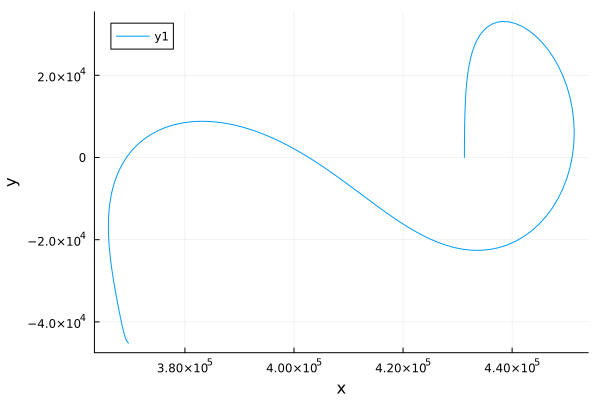

In [56]:
#this is if we rollout our dynamics with the stable initial condition
#almost periodic, can be fixed with a differential corrector
#plot(all_state_in[1,:], all_state_in[2,:], all_state_in[3,:], xlabel="x", ylabel="y", zlabel="z")

plot(all_state_in[1,:], all_state_in[2,:], xlabel="x", ylabel="y")

In [57]:
#fix with a single shooting differential corrector
function differential_corrector(x_0_stm, Tp)
    
    #this is the final time it converges to
    T_f = 0

    #Iterate to bring the δx at T/2 to the desired state
    max_iters = 1000

    #keep z0 fixed and change only x0 and y_dot_0
    for i=1:max_iters
    #for i=1:100

        solution = diff_solve(x_0_stm, Tp)

        #this is the state, STM, and time when y crosses the XZ plane 
        all_state, stm, sol_t = get_state_stm(solution)

        #display(stm)

        T2_state = all_state[:,end]

        #T2_state -> x,y,z, xdot, ydot, zdot
        #desired xdot an xzdot
        xz_d = [0, 0]

        rv = T2_state[1:6]

        rv_dot = three_body_prob_dynamics_scaled(rv)

        #desired state subtracted by state at t/2
        δxz = xz_d - [T2_state[4], T2_state[6]]

        #subset of the state transition matrix

        #all 6 variables 
        #stm_s = [stm[4,1] stm[4,3] stm[4,5]; stm[6,1] stm[6,3] stm[6,5]]

        #to change x and ydot 

        #keep z0 constant
        #stm_s = [stm[4,1] stm[4,5]; stm[6,1] stm[6,5]]
        #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,5]]

        #keep x0 constant
        stm_s = [stm[4,3, end] stm[4,5,end]; stm[6,3,end] stm[6,5,end]]
        dy = [rv_dot[4]; rv_dot[6]]*[stm[2,3,end] stm[2,5,end]]


        #println("this is stm s: ")
        #println(stm_s)


        #keep y0 constant
        #stm_s = [stm[4,1] stm[4,3]; stm[6,1] stm[6,3]]
        #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,3]]

        delta_x0 = (stm_s - dy/rv_dot[2])\δxz
        
        #println("THIS IS CONDITION NUMBER")
        #println(cond((stm_s - dy/rv_dot[2])))

        #delta_x0 = stm_s\δxz

        #update the initial state

        #x_0_stm[1] = x_0_stm[1] + delta_x0[1]
        x_0_stm[3] = x_0_stm[3] + delta_x0[1]
        x_0_stm[5] = x_0_stm[5] + delta_x0[2]

        #x_0_stm[1:6] = x_0_stm[1:6] + delta
        #when delta is below a set tolerance we are done

        println("residual: ", δxz)
        
        #loosen up the tolerance bc of the scaling of the problem
        if norm(δxz) < 1e-6

            #this is the total time, but we use it to ensure we have enough time to find where
            #y crosses the xz plane
            #print("this is sol t: ", sol_t)
            #updating time
                    
            T_f = sol_t[end]*2
            break
        end

    end
    
    corrected_solution = dynamics_integrate(x_0_stm, T_f)

    all_state_final, stm_final, sol_t_final = get_state_stm(corrected_solution)
    
    return all_state_final, stm_final, sol_t_final, corrected_solution
    
end

differential_corrector (generic function with 1 method)

In [58]:
#run the differential corrector to get the corrected solution
all_state_final, stm_final, sol_t_final, full_solution = differential_corrector(x_0_stm, T_scaled)

residual: [1643.9520665946734, -191.49882013184757]
residual: [2.50640377938576, 35.41406163738534]
residual: [-495.1172851568247, 60.68877908842731]
residual: [-24.37546876993494, 8.50685424720485]
residual: [-110.46814192446912, 9.54009309010716]
residual: [-13.136469711447523, 1.7580358490853736]
residual: [-14.472588166878632, 1.0122264537249142]
residual: [-1.505303267632691, 0.12529129664950409]
residual: [-0.11476903723509187, 0.007755367827106863]
residual: [-0.00012003677020844276, 1.8507296361931575e-5]
residual: [-8.464284497666003e-5, -3.1672155774008355e-6]
residual: [1.1112903456945178e-5, 4.156345805856892e-7]
residual: [0.00010115294184219924, 3.78624364506784e-6]
residual: [-0.00010840135247014187, -4.056172106837442e-6]
residual: [4.0602026942756594e-5, 1.5196958162793624e-6]
residual: [-4.491641912241997e-5, -1.6801875776502769e-6]
residual: [8.95029402409035e-5, 3.3480900212831964e-6]
residual: [2.5252954553504204e-5, 9.458764132468768e-7]
residual: [-1.548315565530

([431249.946141646 431249.94614368404 … 431250.3817559771 431249.9493668459; 0.0 2.11865931416171 … -974.2704382779812 -0.003851463980650329; … ; 15649.01638927097 15649.016351075303 … 15640.937642552299 15649.014948352466; 0.0 -0.09679750259452195 … 44.50368193205585 0.0001293855647662], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000061999952 5.74681260289577e-14 … 4.21449737713891e-9 1.5618013565683038e-14; -2.1789856876862402e-14 0.9999999976191183 … 0.0001353861009620931 7.747326020150754e-20; … ; -4.828381202874513e-10 -3.517173033319686e-5 … 0.9999999956810307 2.288957559459435e-15; 5.112447756761017e-6 1.0493422150552927e-10 … 1.6653222599682134e-14 0.9999999971499303;;; 1.0000000245547165 4.529417817983927e-13 … 1.6691269091577298e-8 1.2309520780151584e-13; -1.7173931605969936e-13 0.999999990570658 … 0.0002694299455112233 1.2151753729360987e-18; … ; -1.9122519702650388e-9 -6.999475781107277e-5 … 0.9999999828949762 1.8040687294144393

In [59]:
all_state_final

6×131 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …      4.3125e5      4.3125e5
     0.0           2.11866        4.21631        -974.27         -0.00385146
  2286.77       2286.77        2286.77           2285.38       2286.77
     0.0           0.0301068      0.0599152       -13.9354        0.00219923
 15649.0       15649.0        15649.0           15640.9       15649.0
     0.0          -0.0967975     -0.192635   …     44.5037        0.000129386

In [60]:
sol_t_final

131-element Vector{Float64}:
  0.0
  0.00013538610115700251
  0.00026942994704742514
  0.0004303715711435791
  0.0006830964153669305
  0.0009491675045592131
  0.001277070628775285
  0.0016106543976025993
  0.0019878701330316474
  0.0024459945807384777
  ⋮
 13.87688676653883
 14.013485059891314
 14.148023074242456
 14.28247964970406
 14.41397369914275
 14.543371472173106
 14.66737869572139
 14.789903469175059
 14.852171558441775

In [61]:
sol_t_final[end]/time_scale

3.414975410587678

In [62]:
all_state_final[1:3,1]/L 

3-element Vector{Float64}:
 1.1201297302380415
 0.0
 0.005939661602570558

In [63]:
all_state_final[4:6]/V_

3-element Vector{Float64}:
 0.0
 0.1767781937441762
 0.0

In [64]:
#Finding the unstable direction for the unstable manifold to encode as a constraint

#monodromy = stm_final[:,:,end]

In [65]:
all_state_final

6×131 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …      4.3125e5      4.3125e5
     0.0           2.11866        4.21631        -974.27         -0.00385146
  2286.77       2286.77        2286.77           2285.38       2286.77
     0.0           0.0301068      0.0599152       -13.9354        0.00219923
 15649.0       15649.0        15649.0           15640.9       15649.0
     0.0          -0.0967975     -0.192635   …     44.5037        0.000129386

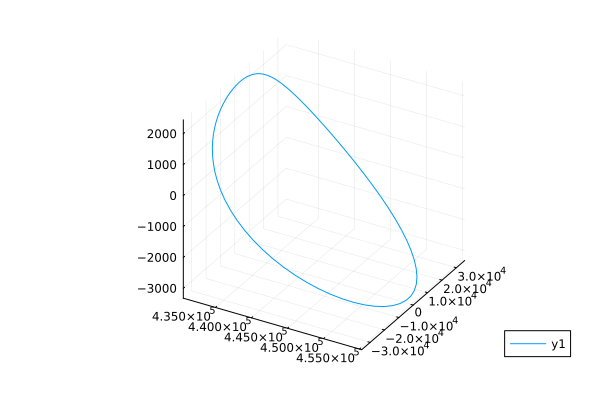

In [66]:
plot(all_state_final[1,:], all_state_final[2,:], all_state_final[3,:])

In [67]:
using DelimitedFiles
#writedlm("xtraj.txt", all_state_final)

In [68]:
final_norm = all_state_final[:,end] - all_state_final[:,1]

6-element Vector{Float64}:
  0.00322519987821579
 -0.003851463980650329
  7.884718979767058e-5
  0.002199234649276377
 -0.001440918504158617
  0.0001293855647662

In [69]:
final_norm

6-element Vector{Float64}:
  0.00322519987821579
 -0.003851463980650329
  7.884718979767058e-5
  0.002199234649276377
 -0.001440918504158617
  0.0001293855647662

In [70]:
#create a 2 orbit horizon reference trajectory
periodic_initial_condition2 = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic2 = [periodic_initial_condition2; Φ_0]

#integrate for 2 revs
solution_periodic2 = dynamics_integrate(x_0_periodic2, 2*sol_t_final[end])

all_state_2, stm_in_2, sol_t_in_2 = get_state_stm(solution_periodic2)

([431249.946141646 431249.94614368404 … 431254.2560939666 431253.84210558556; 0.0 2.11865931416171 … -1155.147976497463 -4.216680720506682; … ; 15649.01638927097 15649.016351075303 … 15636.011893022314 15647.275815398147; 0.0 -0.09679750259452195 … 52.71954343616217 0.15311785966204014], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000061999952 5.74681260289577e-14 … 4.21449737713891e-9 1.5618013565683038e-14; -2.1789856876862402e-14 0.9999999976191183 … 0.0001353861009620931 7.747326020150754e-20; … ; -4.828381202874513e-10 -3.517173033319686e-5 … 0.9999999956810307 2.288957559459435e-15; 5.112447756761017e-6 1.0493422150552927e-10 … 1.6653222599682134e-14 0.9999999971499303;;; 1.0000000245547165 4.529417817983927e-13 … 1.6691269091577298e-8 1.2309520780151584e-13; -1.7173931605969936e-13 0.999999990570658 … 0.0002694299455112233 1.2151753729360987e-18; … ; -1.9122519702650388e-9 -6.999475781107277e-5 … 0.9999999828949762 1.8040687294144393e

In [71]:
#Check when the orbit leave
periodic_initial_condition = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic = [periodic_initial_condition; Φ_0]

#integrate for 3.5 revs
solution_periodic = dynamics_integrate(x_0_stm, 3.5*sol_t_final[end])

all_state_lp, stm_in_lp, sol_t_in_lp = get_state_stm(solution_periodic)

([431249.946141646 431249.94614368404 … 554005.2428719949 557288.0105173714; 0.0 2.11865931416171 … -69190.52364549524 -75399.30097688234; … ; 15649.01638927097 15649.016351075303 … -46181.103118709194 -47985.92575257201; 0.0 -0.09679750259452195 … -761.2070424352357 -752.7103722662881], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000061999952 5.74681260289577e-14 … 4.21449737713891e-9 1.5618013565683038e-14; -2.1789856876862402e-14 0.9999999976191183 … 0.0001353861009620931 7.747326020150754e-20; … ; -4.828381202874513e-10 -3.517173033319686e-5 … 0.9999999956810307 2.288957559459435e-15; 5.112447756761017e-6 1.0493422150552927e-10 … 1.6653222599682134e-14 0.9999999971499303;;; 1.0000000245547165 4.529417817983927e-13 … 1.6691269091577298e-8 1.2309520780151584e-13; -1.7173931605969936e-13 0.999999990570658 … 0.0002694299455112233 1.2151753729360987e-18; … ; -1.9122519702650388e-9 -6.999475781107277e-5 … 0.9999999828949762 1.8040687294144393e

In [72]:
all_state_lp

6×333 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …       5.54005e5  557288.0
     0.0           2.11866        4.21631       -69190.5        -75399.3
  2286.77       2286.77        2286.77           -2892.26        -2992.08
     0.0           0.0301068      0.0599152      25052.3         24725.6
 15649.0       15649.0        15649.0           -46181.1        -47985.9
     0.0          -0.0967975     -0.192635   …    -761.207        -752.71

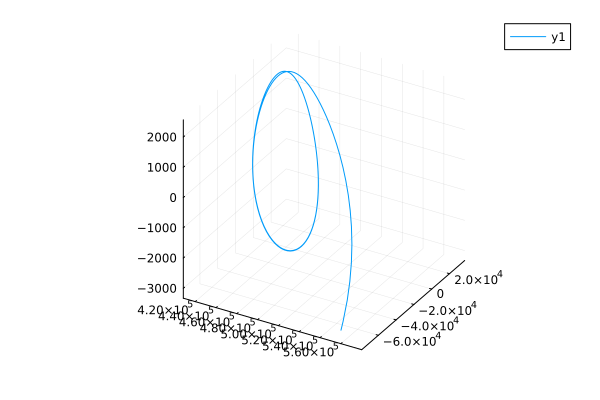

In [73]:
plot(all_state_lp[1,:], all_state_lp[2,:], all_state_lp[3,:], aspectratio=true)

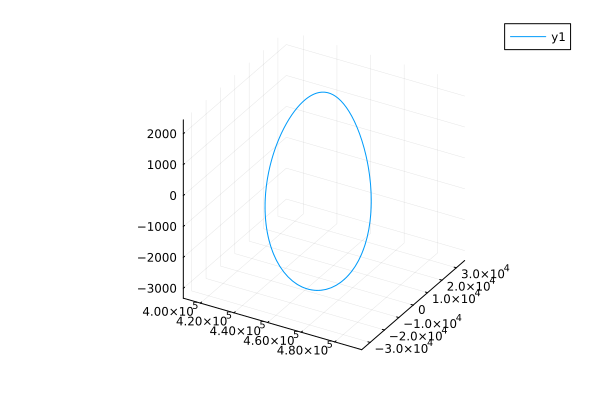

In [74]:
plot(all_state_2[1,:], all_state_2[2,:], all_state_2[3,:], aspectratio=true)

In [75]:
all_state_2

6×216 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …      4.31254e5      4.31254e5
     0.0           2.11866        4.21631       -1155.15          -4.21668
  2286.77       2286.77        2286.77           2284.92        2286.86
     0.0           0.0301068      0.0599152       -13.9857         2.65783
 15649.0       15649.0        15649.0           15636.0        15647.3
     0.0          -0.0967975     -0.192635   …     52.7195         0.153118

In [76]:
all_state_final

6×131 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …      4.3125e5      4.3125e5
     0.0           2.11866        4.21631        -974.27         -0.00385146
  2286.77       2286.77        2286.77           2285.38       2286.77
     0.0           0.0301068      0.0599152       -13.9354        0.00219923
 15649.0       15649.0        15649.0           15640.9       15649.0
     0.0          -0.0967975     -0.192635   …     44.5037        0.000129386

In [77]:
#as seen above, after about 3.5 periods it begins to diverge from the periodic orbit 
#will formulate as a convex optimiztion problem to generate the station keeping 
#maneuvers

In [78]:
#this is the continuous dynamics
#AL2 = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), all_state_final[:,1])

In [79]:
#this is including the slack variable in the control vector
#B = [zeros(3,4); I][1:6, :]

In [80]:
nx = 6 #number of states
nu = 3 #number of controls 

3

In [81]:
sol_t_final[end ]

14.852171558441775

In [82]:
#this is the A tilde to get the discretized dynamics
#Ã = [AL2 B; zeros(4,10)]

#this is the number of knot points in one horizon
N_period = 41  #40 knot points per period per period

#N_h = 82 #horizon 2 periods

N_h = 81 #horizon 2 periods

#this is the time step. (period T is already scaled). for 1 period
# 100 poi
Δt = (sol_t_final[end]/(N_period-1))

0.3713042889610444

In [83]:
sol_t_final[end]/time_scale

3.414975410587678

In [84]:
all_state_final[:,1]

6-element Vector{Float64}:
 431249.946141646
      0.0
   2286.769716989665
      0.0
  15649.01638927097
      0.0

In [86]:
# custom_position_scale = norm(all_state_final[:,1])
# custom_time_scale = sol_t_final[end]
# custom_velocity_scale = custom_position_scale/custom_time_scale

In [87]:
# function get_reference(i,N)
    
#     reference = zeros(nx, N)

#     for k=1:N

#         reference[:,k] = full_solution(horizon[i:end]).u[k][1:6]
        
#     end

#     return reference
    
# end

In [88]:
#Ad = H[1:nx, 1:nx]
#Bd = H[1:nx, nx+1:end]

In [89]:
#umin = 0.5
#umax = 1

In [90]:
#N (number of knot points) 6x6 discrete dynamics jacobians

#this is along 1 period of the reference orbit
all_Ad = zeros(6,6,N_period)
all_Bd = zeros(6,3,N_period)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 41] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [91]:
T_corrected = sol_t_final[end]

14.852171558441775

In [92]:
horizon = LinRange(0, T_corrected, N_period)

41-element LinRange{Float64, Int64}:
 0.0, 0.371304, 0.742609, 1.11391, …, 13.7383, 14.1096, 14.4809, 14.8522

In [93]:
horizon[2]

0.3713042889610444

In [94]:
#used to save the state transition matrix at each knot point
stm_times = zeros((6,6,N_period))

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0


In [95]:
horizon

41-element LinRange{Float64, Int64}:
 0.0, 0.371304, 0.742609, 1.11391, …, 13.7383, 14.1096, 14.4809, 14.8522

In [96]:
full_solution(horizon).u[1][7:end]

36-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 ⋮
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

In [97]:
#get the reference trajectory
reference_trajectory = zeros(nx, N_period)

for k=1:N_period

    reference_trajectory[:,k] = full_solution(horizon).u[k][1:6]
    
    #save the reference state transition matrices at the dedicated timesteps
    
    stm_times[:,:,k] = reshape(full_solution(horizon).u[k][7:end], (6,6)) 
        
end

In [98]:
#monodromy is the stm at the end of the periodic orbit
monodromy_eigen = eigen(stm_times[:,:,end])

stable_dir = real(monodromy_eigen.vectors[:,1])
unstable_dir = real(monodromy_eigen.vectors[:,end])
#find the eigen values of the monodromy

6-element Vector{Float64}:
  0.5935997677778411
 -0.6423215383474878
  0.013967734765510597
  0.40497424701619056
 -0.265176994172325
  0.023329819329140137

In [99]:
#save the unstable directions in a matrix
unstable_directions = zeros(6,N_period)

6×41 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [100]:
#the unstable directions are then the stm at the timestep multiplied by the unstable direction found by the monodromy

for k = 1:N_period
    
    unstable_directions[:,k] = (stm_times[:,:,k]*unstable_dir)/norm(stm_times[:,:,k]*unstable_dir)
    
end

In [101]:
#unstable directions for the unstable manifolds along the orbit
unstable_directions

6×41 Matrix{Float64}:
  0.5936      0.630003    0.669871    0.709854   …   0.563902     0.5936
 -0.642322   -0.611253   -0.574696   -0.534157      -0.666939    -0.642322
  0.0139677   0.0196798   0.024741    0.028827       0.00797906   0.0139677
  0.404974    0.424713    0.434908    0.43676        0.376944     0.404974
 -0.265177   -0.21929    -0.175043   -0.136631      -0.307627    -0.265177
  0.0233298   0.0246805   0.0244821   0.0229326  …   0.0205333    0.0233298

In [102]:
#[unstable_directions[1:3, 1]; zeros(3)]

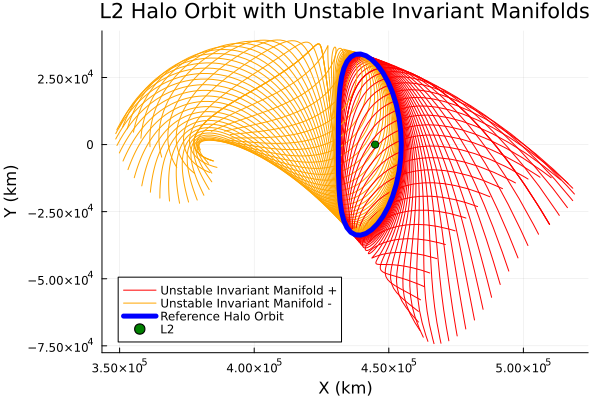

In [103]:
#plot the manifolds
#+ manifold to the right
# - manifold to the left
epz = 3
#plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Orbit")

plot(reference_trajectory[1,:], reference_trajectory[2,:], label=nothing)

all_state_mplus = 0

all_state_mminus = 0
for i=1:41

    #initial_state = reference_trajectory[:,i] + epz.*unstable_directions[:,i]

    initial_state_plus = reference_trajectory[:,i] + epz.*[unstable_directions[1:3,i];zeros(3)]

    initial_state_minus = reference_trajectory[:,i] - epz.*[unstable_directions[1:3,i];zeros(3)]

    #initial_state = reference_trajectory[:,i] - epz.*unstable_directions[:,i]

    inv_manifold_plus = just_dynamics_integrate(initial_state_plus, 1.5*sol_t_final[end])

    inv_manifold_minus = just_dynamics_integrate(initial_state_minus, 1.45*sol_t_final[end])

    all_state_mplus = get_state(inv_manifold_plus)

    all_state_mminus = get_state(inv_manifold_minus)

    #plot!(all_state_m[1,:], all_state_m[2,:], all_state_m[3,:], color="red", legend=false)

    plot!(all_state_mplus[1,:], all_state_mplus[2,:], color="red", label=nothing)
    plot!(all_state_mminus[1,:], all_state_mminus[2,:], color="orange", label=nothing)

end

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Orbit", linewidth = 5)


plot!(all_state_mplus[1,:], all_state_mplus[2,:], color="red", label = "Unstable Invariant Manifold +")
plot!(all_state_mminus[1,:], all_state_mminus[2,:], color="orange", label = "Unstable Invariant Manifold -")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], label="Reference Halo Orbit", linewidth = 5, xlabel = "X (km)", ylabel = "Y (km)", color="blue")
orbit_manifolds = scatter!([XL2[1]*L], [0], markercolor = "green", label = "L2", legend=true, title = "L2 Halo Orbit with Unstable Invariant Manifolds")

#savefig(orbit_manifolds, "orbit_manifolds")

In [104]:
XL2*L 

6-element Vector{Float64}:
 444936.76654147316
      0.0
      0.0
      0.0
      0.0
      0.0

In [105]:
#two orbits worth of data
unstable_constraint = cat(unstable_directions, unstable_directions, dims=2)

6×82 Matrix{Float64}:
  0.5936      0.630003    0.669871    0.709854   …   0.563902     0.5936
 -0.642322   -0.611253   -0.574696   -0.534157      -0.666939    -0.642322
  0.0139677   0.0196798   0.024741    0.028827       0.00797906   0.0139677
  0.404974    0.424713    0.434908    0.43676        0.376944     0.404974
 -0.265177   -0.21929    -0.175043   -0.136631      -0.307627    -0.265177
  0.0233298   0.0246805   0.0244821   0.0229326  …   0.0205333    0.0233298

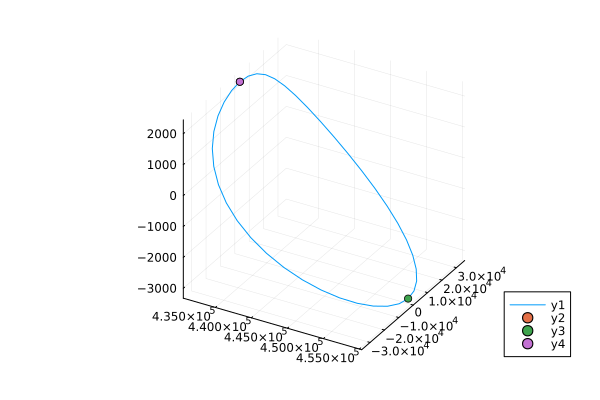

In [106]:
plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])
scatter!([reference_trajectory[1,21]], [reference_trajectory[2,21]], [reference_trajectory[3,21]])
scatter!([reference_trajectory[1,end]], [reference_trajectory[2,end]], [reference_trajectory[3,end]])

In [107]:
#obtain the reference trajectory at the knot points that we made up

#reference_trajectory = get_reference(1,N_period)

In [108]:
#goal is to have a look ahead of 2 orbits and apply an MPC controller 

#3 periods worth of data (just using the same orbit over the 3 periods)
#reference_trajectory_all = [reference_trajectory reference_trajectory reference_trajectory]

In [109]:
#inputs are in the custom scaled units

function three_body_prob_dynamics_wcontrol_scaled_RK4(x, u)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    u_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    u_original = u/acceleration_scale
    
    x_original = [q_original; v_original; u_original]

    ẋ_original = zeros(eltype(x),9)

    #calculate the original xdot (no scaling)

    #xoriginal is in the CR3BP units
    ẋ_original = three_body_prob_dynamics_wcontrol(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    u_scaled = ẋ_original[7:9]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_wcontrol_scaled_RK4 (generic function with 1 method)

In [110]:
sol_t_final[end]

14.852171558441775

In [111]:
#RK4 integrator with a zero order hold

function RK4_integrator(x, u)

    f1 = three_body_prob_dynamics_wcontrol_scaled_RK4(x, u)
    f2 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+0.5*Δt*f1, u)
    f3 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+0.5*Δt*f2, u)
    f4 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+ Δt*f3, u)

    xnext = x + (Δt/6.0)*(f1+2*f2+2*f3+f4)

    return xnext

end



RK4_integrator (generic function with 1 method)

In [112]:
reference_trajectory

6×41 Matrix{Float64}:
     4.3125e5  431267.0        4.31338e5  …  431267.0        4.3125e5
     0.0         5775.21   11343.6            -5775.22      -0.00385146
  2286.77        2237.81    2094.63            2237.81    2286.77
     0.0          101.372    306.583           -101.372      0.00219923
 15649.0        15364.7    14545.9            15364.7    15649.0
     0.0         -262.025   -504.475      …     262.025      0.000129386

In [113]:
u0 = zeros(3)
Ak_rk4 = ForwardDiff.jacobian(x_-> RK4_integrator(x_, u0), reference_trajectory[:,1])

6×6 Matrix{Float64}:
  1.04672       0.00116552   0.00258833   …  0.03218     0.000318583
 -0.000431504   0.982282    -5.0311e-5       0.367318    4.24364e-6
  0.00259016    9.59182e-5   0.978703        3.13769e-5  0.368663
  0.252156      0.00924403   0.0138642       0.17581     0.00254655
 -0.00360089   -0.0944522   -0.000409083     0.968211    4.27982e-5
  0.0138817     0.00076016  -0.113972     …  0.00033015  0.978825

In [114]:
Bk_rk4 = ForwardDiff.jacobian(u_-> RK4_integrator(reference_trajectory[:,1], u_), u0)

6×3 Matrix{Float64}:
  0.0692973    0.00396111  2.93345e-5
 -0.00388576   0.0685635   1.65086e-6
  2.93345e-5   1.65086e-6  0.0686883
  0.375142     0.032364    0.000311353
 -0.0311828    0.367385    1.241e-5
  0.000309142  3.89267e-5  0.36868

In [115]:
for i=1:N_period

    #get the discrete dynamics jacobians for the entire reference trajectory along the knot points

    #Ak = ForwardDiff.jacobian(x-> three_body_prob_dynamics_scaled(x), reference_trajectory[:,i])
    all_Ad[:,:,i] = ForwardDiff.jacobian(x_-> RK4_integrator(x_, zeros(3)), reference_trajectory[:,i])

    #this is including the slack variable in the control vector (this is control on accelerations/thrust)
    #Bk = [zeros(3,3); I]

    all_Bd[:,:,i] = ForwardDiff.jacobian(u_-> RK4_integrator(reference_trajectory[:,i], u_), zeros(3))

    #this is the A tilde to get the discretized dynamics
    # Ãk = [Ak Bk; zeros(3,9)]

    # H = exp(Ãk*Δt)

    # all_Ad[:,:,i] = H[1:nx, 1:nx]

    # all_Bd[:,:,i] = H[1:nx, nx+1:end]
    
    
end

In [116]:
all_Bd[:,:,1]

6×3 Matrix{Float64}:
  0.0692973    0.00396111  2.93345e-5
 -0.00388576   0.0685635   1.65086e-6
  2.93345e-5   1.65086e-6  0.0686883
  0.375142     0.032364    0.000311353
 -0.0311828    0.367385    1.241e-5
  0.000309142  3.89267e-5  0.36868

In [117]:
all_Ad[:,:,1] 

6×6 Matrix{Float64}:
  1.04672       0.00116552   0.00258833   …  0.03218     0.000318583
 -0.000431504   0.982282    -5.0311e-5       0.367318    4.24364e-6
  0.00259016    9.59182e-5   0.978703        3.13769e-5  0.368663
  0.252156      0.00924403   0.0138642       0.17581     0.00254655
 -0.00360089   -0.0944522   -0.000409083     0.968211    4.27982e-5
  0.0138817     0.00076016  -0.113972     …  0.00033015  0.978825

In [118]:
all_Ad_1 = cat(all_Ad, all_Ad[:,:,2:end], dims=3)
all_Bd_1 = cat(all_Bd, all_Bd[:,:,2:end], dims=3)

6×3×81 Array{Float64, 3}:
[:, :, 1] =
  0.0692973    0.00396111  2.93345e-5
 -0.00388576   0.0685635   1.65086e-6
  2.93345e-5   1.65086e-6  0.0686883
  0.375142     0.032364    0.000311353
 -0.0311828    0.367385    1.241e-5
  0.000309142  3.89267e-5  0.36868

[:, :, 2] =
  0.0692656    0.00402781  2.63571e-5
 -0.00381906   0.0685871   4.37093e-6
  2.63571e-5   4.37093e-6  0.0686965
  0.374737     0.0330256   0.000274268
 -0.030512     0.367682    3.99156e-5
  0.000269826  6.31595e-5  0.368787

[:, :, 3] =
  0.0692132    0.00407449  2.14464e-5
 -0.00377237   0.068625    5.75985e-6
  2.14464e-5   5.75985e-6  0.0687109
  0.374151     0.0334585   0.00021943
 -0.0300649    0.368102    5.32537e-5
  0.000214041  7.17612e-5  0.368954

;;; … 

[:, :, 79] =
  0.0692656     0.00381945   2.63732e-5
 -0.00402742    0.068587    -4.35713e-6
  2.63732e-5   -4.35713e-6   0.0686965
  0.374973      0.0308243    0.000292584
 -0.0327187     0.367509    -5.26963e-5
  0.000296047  -2.75461e-5   0.368724

[

In [119]:
#concatenate jacobians for two periods

# all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
# all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

In [120]:
N_period

41

In [121]:
num_revs = 10

10

In [122]:
#1 revolution is 14 days
T*time_scale/60/60/24

0.0001715060863045259

In [123]:
T*time_scale

14.818125856711038

In [124]:
N_h

81

In [125]:
#compute backward ricatti recursion

#cost to go matrices
#P = zeros((6,6,N_period*num_revs)) #size state x state (6x6) 
#K = zeros((3,6,N_period*num_revs)) #size control x state (3x6)

#cost to go matrices for 16 revs
P = zeros((6,6,N_period+((N_period-1)*15))) #size state x state (6x6) 
K = zeros((3,6,N_period+((N_period-1)*15))) #size control x state (3x6)

#state cost weight matrix
Q = 1.0*Matrix(I,6,6).*1e-3

#terminal cost weight matrix
Qf = 1.0*Matrix(I,6,6).*1e-3

#control cost weight matrix
R = 1.0*Matrix(I,3,3).*1e3

3×3 Matrix{Float64}:
 1000.0     0.0     0.0
    0.0  1000.0     0.0
    0.0     0.0  1000.0

In [126]:
N_period+((N_period-1)*15)

641

In [127]:
P

6×6×641 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 639] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 640] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0

In [128]:
#1:(N_period*num_revs) - 1

In [129]:
#all_Ad_rev = all_Ad

In [130]:
all_Ad_16 = all_Ad
all_Bd_16 = all_Bd

6×3×41 Array{Float64, 3}:
[:, :, 1] =
  0.0692973    0.00396111  2.93345e-5
 -0.00388576   0.0685635   1.65086e-6
  2.93345e-5   1.65086e-6  0.0686883
  0.375142     0.032364    0.000311353
 -0.0311828    0.367385    1.241e-5
  0.000309142  3.89267e-5  0.36868

[:, :, 2] =
  0.0692656    0.00402781  2.63571e-5
 -0.00381906   0.0685871   4.37093e-6
  2.63571e-5   4.37093e-6  0.0686965
  0.374737     0.0330256   0.000274268
 -0.030512     0.367682    3.99156e-5
  0.000269826  6.31595e-5  0.368787

[:, :, 3] =
  0.0692132    0.00407449  2.14464e-5
 -0.00377237   0.068625    5.75985e-6
  2.14464e-5   5.75985e-6  0.0687109
  0.374151     0.0334585   0.00021943
 -0.0300649    0.368102    5.32537e-5
  0.000214041  7.17612e-5  0.368954

;;; … 

[:, :, 39] =
  0.0692656     0.00381945   2.63732e-5
 -0.00402742    0.068587    -4.35713e-6
  2.63732e-5   -4.35713e-6   0.0686965
  0.374973      0.0308243    0.000292584
 -0.0327187     0.367509    -5.26963e-5
  0.000296047  -2.75461e-5   0.368724

[

In [131]:
for i = 2:16
    all_Ad_16 = cat(all_Ad_16, all_Ad[:,:,2:end], dims = 3)
    all_Bd_16 = cat(all_Bd_16, all_Bd[:,:,2:end], dims = 3)
end


In [132]:
# all_Ad_4 = cat(all_Ad_1, all_Ad_1, dims=3)
# all_Bd_4 = cat(all_Bd_1, all_Bd_1, dims=3)

# all_Ad_8 = cat(all_Ad_4, all_Ad_4, dims=3)
# all_Bd_8 = cat(all_Bd_4, all_Bd_4, dims=3)

# all_Ad_16 = cat(all_Ad_8, all_Ad_8, dims=3)
# all_Bd_16 = cat(all_Bd_8, all_Bd_8, dims=3)

In [133]:
# for i = 1:num_revs
#     all_Ad_rev = (all_Ad_rev, all_Ad, dims=3)
# end

In [134]:
# P[:,:,end] = Qf

# for k = reverse(1:(N_period*num_revs) - 1)
    
#     K[:,:,k] = (R + all_Bd_1[:,:,k]'*P[:,:,k+1]*all_Bd_1[:,:,k])\(all_Bd_1[:,:,k]'*P[:,:,k+1]*all_Ad_1[:,:, k]) # ricatti recursion for both A and B matrices changing
#     P[:,:,k] = Q + all_Ad_1[:,:,k]'*P[:,:,k+1]*all_Ad_1[:,:,k] - all_Ad_1[:,:,k]'*P[:,:,k+1]*all_Bd_1[:,:,k]*K[:,:,k]
 
# end 

In [135]:
#Ricatti recursion over 2 periods
P[:,:,end] = Qf

for k = reverse(1:640)
    #println(k)    
    K[:,:,k] = (R + all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k])\(all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:, k]) # ricatti recursion for both A and B matrices changing
    P[:,:,k] = Q + all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:,k] - all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k]*K[:,:,k]
        
end

In [136]:
P

6×6×641 Array{Float64, 3}:
[:, :, 1] =
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

[:, :, 2] =
 1791.63    126.901    53.8867   1481.15    1744.4     21.3351
  126.901     9.15195   3.84318   105.423    123.276    1.47771
   53.8867    3.84318   1.87429    44.7436    52.3419  -0.11799
 1481.15    105.423    44.7436   1229.03    1437.68    17.2838
 1744.4     123.276    52.3419   1437.68    1703.26    20.4681
   21.3351    1.47771  -0.11799    17.2838    20.4681   9.94354

[:, :, 3] =
 1647.31     231.473     41.7948    1360.5      1708.33     5.49429
  231.473     32.6689     5.87698    191.238     240.263    0.714936
   41.7948     5.87698

In [137]:
P[:,:,1]

6×6 Matrix{Float64}:
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

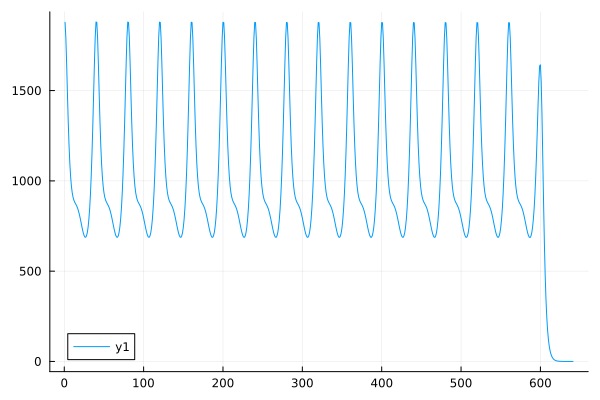

In [138]:
plot(P[1,1,:])
#plot(P[2,2,:])
#plot(P[3,3,:])
#plot(P[4,4,:])
#plot(P[5,5,:])
#plot(P[6,6,:])

In [139]:
#cost to go converges and is periodic! will get one orbit of the cost to go to make a constraint
V = P[:,:,1:41]

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

[:, :, 2] =
 1791.63    126.901    53.8867   1481.15    1744.4     21.3351
  126.901     9.15195   3.84318   105.423    123.276    1.47771
   53.8867    3.84318   1.87429    44.7436    52.3419  -0.11799
 1481.15    105.423    44.7436   1229.03    1437.68    17.2838
 1744.4     123.276    52.3419   1437.68    1703.26    20.4681
   21.3351    1.47771  -0.11799    17.2838    20.4681   9.94354

[:, :, 3] =
 1647.31     231.473     41.7948    1360.5      1708.33     5.49429
  231.473     32.6689     5.87698    191.238     240.263    0.714936
   41.7948     5.87698 

In [140]:
V[:,:,1]

6×6 Matrix{Float64}:
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

In [141]:
#cost to go matrices for 2 orbits worth of data
V_2orbits = cat(V, V[:,:,2:end], dims=3)

6×6×81 Array{Float64, 3}:
[:, :, 1] =
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

[:, :, 2] =
 1791.63    126.901    53.8867   1481.15    1744.4     21.3351
  126.901     9.15195   3.84318   105.423    123.276    1.47771
   53.8867    3.84318   1.87429    44.7436    52.3419  -0.11799
 1481.15    105.423    44.7436   1229.03    1437.68    17.2838
 1744.4     123.276    52.3419   1437.68    1703.26    20.4681
   21.3351    1.47771  -0.11799    17.2838    20.4681   9.94354

[:, :, 3] =
 1647.31     231.473     41.7948    1360.5      1708.33     5.49429
  231.473     32.6689     5.87698    191.238     240.263    0.714936
   41.7948     5.87698 

In [142]:
V_first = V_2orbits[:,:,1]

6×6 Matrix{Float64}:
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

In [143]:
V_first'

6×6 adjoint(::Matrix{Float64}) with eltype Float64:
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

In [144]:
difference = V_first - V_first'

6×6 Matrix{Float64}:
  0.0           2.089e-12     9.23706e-13  …   2.50111e-12  -1.45661e-12
 -2.089e-12     0.0          -1.82299e-13      1.20082e-12   4.11171e-13
 -9.23706e-13   1.82299e-13   0.0              6.39488e-13   1.67533e-13
 -1.36424e-12   3.78719e-12   1.54898e-12      5.68434e-12  -2.08544e-12
 -2.50111e-12  -1.20082e-12  -6.39488e-13      0.0           1.00897e-12
  1.45661e-12  -4.11171e-13  -1.67533e-13  …  -1.00897e-12   0.0

In [145]:
difference2 = V_2orbits[:,:,2] - V_2orbits[:,:,2]'

6×6 Matrix{Float64}:
  0.0           1.84741e-12   5.96856e-13  …   2.27374e-12  -1.39977e-12
 -1.84741e-12   0.0          -1.62537e-13      1.36424e-12   6.03961e-13
 -5.96856e-13   1.62537e-13   0.0              5.18696e-13   1.87905e-13
 -1.13687e-12   3.87956e-12   1.09424e-12      5.91172e-12  -1.9682e-12
 -2.27374e-12  -1.36424e-12  -5.18696e-13      0.0           1.20792e-12
  1.39977e-12  -6.03961e-13  -1.87905e-13  …  -1.20792e-12   0.0

In [146]:
symmetric_v1 = (V_first + V_first')/2

6×6 Matrix{Float64}:
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

In [147]:
#needed for the quadratic constraint
invsymmetricv1 = inv(symmetric_v1)

6×6 Matrix{Float64}:
 120.482    125.0       3.03034   -81.6922   -54.3617   -4.69887
 125.0      137.863     2.85079   -85.4866   -55.6143   -4.92428
   3.03034    2.85079   4.87823    -2.23434   -1.39923   0.801581
 -81.6922   -85.4866   -2.23434    55.5254    36.7336    3.14874
 -54.3617   -55.6143   -1.39923    36.7336    24.6556    2.11428
  -4.69887   -4.92428   0.801581    3.14874    2.11428   0.473454

In [148]:
invsymmetricv1 - invsymmetricv1'

6×6 Matrix{Float64}:
  0.0          -2.84217e-12   5.75096e-13  …  -3.62377e-13   6.66134e-14
  2.84217e-12   0.0           6.42153e-13     -1.66978e-12  -4.70735e-14
 -5.75096e-13  -6.42153e-13   0.0              2.51799e-13   2.43139e-14
 -3.69482e-13   1.56319e-12  -3.92575e-13      4.1922e-13   -2.93099e-14
  3.62377e-13   1.66978e-12  -2.51799e-13      0.0          -4.44089e-14
 -6.66134e-14   4.70735e-14  -2.43139e-14  …   4.44089e-14   0.0

In [149]:
display(V_first)

6×6 Matrix{Float64}:
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

In [150]:
#far_deviation = [1, 0, 1, 0, 1, 0]

In [151]:
#cost to go for this far deviation
#far_deviation'*inv(V_first)*far_deviation

In [152]:
#get the initial delta x
#this is some noise on the reference trajectory

#some arbitrary deviation from the reference trajectory
#x_initial_ref = [1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5]

#this is working
#x_initial_ref = [1e-9, 0, 0, 0, 1e-9, 0]

#this is working. Pretty far deviation in x = 385 km, and vy off by ~1e-3 km/s
#x_initial_ref = [1e-3, 0, 0, 0, 1e-3, 0]


#off by 385 km meters and ~1 mm/s

#x_initial_ref = [1e-3, 0, 0, 0, 1e-6, 0]


#try a small deviation
#works great with a small deviation
#x_initial_ref = [1e-9, 0, 0, 0, 1e-9, 0]

#trying a larger deviation
#these are in CR3BP units
x_initial_ref = [1e-6, 0, 0, 0, 1e-6, 0]

x_initial_ref_scaled = [x_initial_ref[1:3]*L; x_initial_ref[4:6]*V_]

#ensure that the initial deviation is in the unstable manifold direction
#x_initial_ref = [1e-9, -1e-9, 1e-9, 1e-9, -1e-9, 1e-9]

6-element Vector{Float64}:
 0.385
 0.0
 0.0
 0.0
 0.08852345449302065
 0.0

In [153]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.385
 0.0
 0.0
 0.0
 0.08852345449302065
 0.0

In [154]:
x_initial_ref_scaled'*V[:,:,1]*x_initial_ref_scaled

407.912335454081

In [155]:
V[:,:,20]

6×6 Matrix{Float64}:
  794.569   -252.913    -23.5578   1300.91     504.658   -26.2258
 -252.913     80.7081     7.56067  -413.675   -161.035     8.04713
  -23.5578     7.56067    1.14244   -38.6294   -14.9543   -1.35379
 1300.91    -413.675    -38.6294   2132.99     821.921   -42.3328
  504.658   -161.035    -14.9543    821.921    326.976   -16.9576
  -26.2258     8.04713   -1.35379   -42.3328   -16.9576   14.9996

In [156]:
V[:,:,end]

6×6 Matrix{Float64}:
 1877.92    -20.2159    62.5995    1595.12    1718.71    37.8908
  -20.2159    0.484219  -0.633542   -16.3083   -19.1852  -0.394736
   62.5995   -0.633542   2.60357     53.3928    57.215   -0.26388
 1595.12    -16.3083    53.3928    1358.85    1455.98    31.9482
 1718.71    -19.1852    57.215     1455.98    1577.34    34.3221
   37.8908   -0.394736  -0.26388     31.9482    34.3221   8.37533

In [157]:
test = eigen(V[:,:,20]).values

6-element Vector{Float64}:
    0.0034536236353028974
    0.11723570599835496
    0.2199819984365143
    9.069440179687561
   14.525283597421641
 3327.447516951693

In [158]:
1/sqrt(test[6])

0.017335820156121864

In [159]:
#concatenate unstable directions for 2 orbits

unstable_directions_2 = cat(unstable_directions, unstable_directions[:, 2:end], dims=2)

6×81 Matrix{Float64}:
  0.5936      0.630003    0.669871    0.709854   …   0.563902     0.5936
 -0.642322   -0.611253   -0.574696   -0.534157      -0.666939    -0.642322
  0.0139677   0.0196798   0.024741    0.028827       0.00797906   0.0139677
  0.404974    0.424713    0.434908    0.43676        0.376944     0.404974
 -0.265177   -0.21929    -0.175043   -0.136631      -0.307627    -0.265177
  0.0233298   0.0246805   0.0244821   0.0229326  …   0.0205333    0.0233298

In [160]:
# V_2orbits

In [162]:
#these are working
tube_pose_r = 1000
tube_vel_r = 1000

# tube_pose_r = 1
# tube_vel_r = 20

20

In [163]:
x_initial_ref[:,1]

6-element Vector{Float64}:
 1.0e-6
 0.0
 0.0
 0.0
 1.0e-6
 0.0

In [164]:
# c_test= unstable_directions[:,1]/tan(pi/6)

# manifold_constraint_test = norm(x_initial_ref[:,1]) - c_test'*(x_initial_ref[:,1])

In [165]:
# dot(x_initial_ref[:,1], unstable_directions[:,1])

In [166]:
# dot(reference_trajectory[:,1] + x_initial_ref, unstable_directions[:,1])

In [167]:
# test = (reference_trajectory[:,1] + x_initial_ref)/norm(reference_trajectory[:,1] + x_initial_ref)

In [168]:
# dot(test, unstable_directions[:,1])

In [169]:
# L

In [170]:
# dot(x_initial_ref, unstable_directions[:,1])

In [171]:
all_Ad

6×6×41 Array{Float64, 3}:
[:, :, 1] =
  1.04672       0.00116552   0.00258833   …  0.03218     0.000318583
 -0.000431504   0.982282    -5.0311e-5       0.367318    4.24364e-6
  0.00259016    9.59182e-5   0.978703        3.13769e-5  0.368663
  0.252156      0.00924403   0.0138642       0.17581     0.00254655
 -0.00360089   -0.0944522   -0.000409083     0.968211    4.27982e-5
  0.0138817     0.00076016  -0.113972     …  0.00033015  0.978825

[:, :, 2] =
 1.04471      0.00728049    0.00238289   …  0.0328983    0.000287544
 0.00571035   0.983671      0.000212577     0.367573     3.5243e-5
 0.00236898   0.000348162   0.979299        5.96173e-5   0.368751
 0.239938     0.0413802     0.0125897       0.181322     0.00226528
 0.0287575   -0.0863362     0.000965359     0.970499     0.000278993
 0.0124803    0.0020421    -0.110212     …  0.000534113  0.979635

[:, :, 3] =
 1.0406       0.0118637     0.00198334  …  0.0333965    0.00023489
 0.0103511    0.986562      0.00037818     0.367985     5.2

In [172]:
#this is the reference trajectory for 2 orbits starting at the beginning
reference_trajectory2 = [reference_trajectory reference_trajectory[:,2:end]]

6×81 Matrix{Float64}:
     4.3125e5  431267.0        4.31338e5  …  431267.0        4.3125e5
     0.0         5775.21   11343.6            -5775.22      -0.00385146
  2286.77        2237.81    2094.63            2237.81    2286.77
     0.0          101.372    306.583           -101.372      0.00219923
 15649.0        15364.7    14545.9            15364.7    15649.0
     0.0         -262.025   -504.475      …     262.025      0.000129386

In [173]:
reference_trajectory_half = cat(reference_trajectory[:,21:end], reference_trajectory[:,2:21], dims=2)

#this is the reference trajectory starting at the half 21
reference_trajectory2_2 = cat(reference_trajectory_half, reference_trajectory_half[:,2:end], dims=2)

6×81 Matrix{Float64}:
      4.5462e5         4.54408e5  …       4.54408e5       4.5462e5
      4.38578e-5   -5115.62            5115.62            4.38578e-5
  -3158.04         -3131.97           -3131.97        -3158.04
      3.00529e-5   -1134.14            1134.14            3.00529e-5
 -13831.2         -13670.1           -13670.1        -13831.2
     -4.40886e-7     140.265      …    -140.265          -4.40886e-7

In [174]:
#get the reference trajectory when you are starting at the half


In [175]:
#dynamics_wcontrol_integrate([reference_trajectory2[:,1]; zeros(3)], Δt).u[end][1:6]

In [176]:
#cost to go level set
#works with 0.1

#THIS EPSILON IS WORKING
#epsilon = 1

epsilon = 1

umax = 0.025

0.025

In [177]:
x_initial_ref'*P[:,:,1]*x_initial_ref

6.892847623859079e-9

In [178]:
P[:,:,end]

6×6 Matrix{Float64}:
 0.001  0.0    0.0    0.0    0.0    0.0
 0.0    0.001  0.0    0.0    0.0    0.0
 0.0    0.0    0.001  0.0    0.0    0.0
 0.0    0.0    0.0    0.001  0.0    0.0
 0.0    0.0    0.0    0.0    0.001  0.0
 0.0    0.0    0.0    0.0    0.0    0.001

In [179]:
P[:,:,1]

6×6 Matrix{Float64}:
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

In [180]:
#lower bound as 10 mm/s. Converting to an acceleration based off of our discretization as well as the units that we are using which 
#is km/day
lower_bound = 10/(Δt*86400)*(86400^2/1e6)

2.3269324532112985

In [181]:
# #10 mm/s
# Tmin = lower_bound
# #1 m/s
# Tmax = 100*lower_bound

In [182]:
#formulate the problem at every solve


#pass in the initial condition, along with jacobians of the current reference trajectory 

#bias is a 6xN_h-1 matrix
function update_prob(x_initial_k, all_Ad_k, all_Bd_k, P_k, unstable_directions_k, bias, reference_traj_k)
    
    #clear the constraints and decision variables every run
    #cons = 0
    #U = 0
    
    X = Variable(nx,N_h)
        
    U = Variable(nu, N_h-1)
    
    #initial state constraint
    cons = Constraint[X[:,1] == x_initial_k]

    #state constraints
    #Dynamics constraint (for the entire horizon)
    
    # for k=1:(N_h-1)
    #     #these are the dynamics for delta x
        
    #     #all_Ad_k will have the 120 jacobians that are associated to the reference trajectory at the moment. 
        
    #     push!(cons, X[:,k+1] == all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k])
    # end


    #dynamics constraint with bias
    for k=1:(N_h-1)
        #these are the dynamics for delta x
        
        #all_Ad_k will have the 120 jacobians that are associated to the reference trajectory at the moment. 
        #check sign on the bias. parenthesis
        #push!(cons, zeros(6)== X[:,k+1] - all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k] - bias[:,k])
        
        #kinda working
        #push!(cons, zeros(6)== X[:,k+1] - (all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k]) - bias[:,k])

        #Linear affine term in terms of Δx and Δu (the integrator is there because the reference trajectory is not dynamically feasible)
        #(x̄+Δx) - (f(x̄,ū) + AΔx + BΔu) - bias
        push!(cons, zeros(6)== reference_traj_k[:,k+1] + X[:,k+1] - (dynamics_wcontrol_integrate([reference_traj_k[:,k]; zeros(3)], Δt).u[end][1:6] + all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[1:3,k]) - bias[:,k])

        
        #in terms of x's
        #prob.constraints += X[:,i+1] == rk4(model, dynamics, X̄[i], Ū[i], params.dt) + A[i]*(X[:,i] - X̄[i]) + B[i]*(U[:,i] - Ū[i])
        #in terms of deltas
        #prob.constraints += X̄[i+1] + ΔX[:,i+1] == rk4(model, dynamics, X̄[i], Ū[i], params.dt) + A[i]*ΔX[:,i] + B[i]*ΔU[:,i]


    end

    
    #already propagating the deltas since we are linearizing the dynamics about the reference trajectories
    
#     for k=1:(N_h-1)        
#         #Box constraints on the deviation from the reference trajectory
                
#         push!(cons, X[1,k] <= xmax)
#         push!(cons, X[1,k] >= -xmax)
#         push!(cons, X[2,k] <= ymax)
#         push!(cons, X[2,k] >= -ymax)
#         push!(cons, X[3,k]<= zmax)
#         push!(cons, X[3,k] >= -zmax)
         
#     end
    
    
    #tube constraint
    #for k=2:(N_h-1) #this was there before and works
    #THIS WORKS and gives nice impluses. removes the noise. HIGH tube pose r
    for k=1:N_h 
       push!(cons, norm(X[1:3,k],2) <= tube_pose_r)
    
       push!(cons, norm(X[4:6,k],2) <= tube_vel_r)
         
    end
    
    
    #cost to go constraint (Working, most current)
    # for k=2:N_h
        
    #    costtogo = P_k[:,:,k]
        
    #    costtogo_hermitian = (costtogo + costtogo')/2
        
    #    #relaxing bc of the manifold constraint
    #    ctg_constraint = quadform(X[:,k], costtogo_hermitian) <= epsilon
        
    #    push!(cons, ctg_constraint)
                
    # end
    
    #manifold constraint (useful)
    #the delta x needs to be normalized
    #exits to the left with the negative sending
    #this is what is used. for some reason it is being infeasbile in problem 2
   #for k=1:N_h
#     for k=2:N_h 
        
#       #this works the best. investigate why 
#       #manifold goes to the left.  (w no ctg constraint)
#       #manifold_constraint = dot(X[:,k], unstable_directions_k[:,k])
        
#       #push!(cons, manifold_constraint >= 0.5*norm(X[:,k]))
        
        
#       #testing  (working) 
#       #goes left with positive unstable direction
#       manifold_constraint = dot(X[:,k], 1*unstable_directions_k[:,k])
        
#       #push!(cons, manifold_constraint >= 0.1*norm(X[:,k]))

#       #push!(cons, manifold_constraint >= 0)

#       #trying out 
#       push!(cons, manifold_constraint > 0)

                
        
#    end



for k = 2:N_h
#to have this at 1, the initial deviation has to satisfy this constraint off the bat. 
#for k = 1:N_h
            
    #manifold goes to the right
    #manifold_constraint = dot(X[:,k], unstable_directions_k[:,k])
    manifold_constraint = X[:,k]'*unstable_directions_k[:,k]
    
    #currently working
    #push!(cons, manifold_constraint > 0)

    #add some slack (works with the positive stable directions. negative stable directions still some that don't satisfy fully)
    #push!(cons, manifold_constraint > 1e-6)

    #will try bumping up the slack (tried 1e-5, worked better but not 100%)
    #1e-4 works good 
    #works good 1e-3
    #works with 1e-1 but at a higher cost
    push!(cons, manifold_constraint > 1e-2)
    
end

   #manifold glideslope constraint for the whole unstable direction

#    for k=2:N_h
#     for k=1:N_h

#         #works with pi/5 too
#         c = unstable_directions_k[:,k]/tan(pi/6)

#         manifold_constraint = norm(X[:,k]) - c'*(X[:,k])

#         push!(cons, manifold_constraint <= 0)

#    end

#currently the one being used
# for k=2:N_h
        
#     #works with pi/5 too
#     c = unstable_directions_k[:,k]/tan(pi/6)
#     #c = unstable_directions_k[:,k]/tan((pi/2) - deg2rad(60)

#     manifold_constraint = norm(X[:,k]) - c'*X[:,k]

#     push!(cons, manifold_constraint <= 0)

# end

    
     
    #Controls Constraint
    #convexification constraint

    # for k=1:(N_h-1)

    #     push!(cons, Tmin <= U[1,k])
    #     push!(cons, Tmin <= U[2,k])
    #     push!(cons, Tmin <= U[3,k])

    # end
    
    #not working
    # for k=1:(N_h-1)

    #     σ1 = U[4,k]

    #     push!(cons, Tmin <= σ1)

    #     push!(cons, norm(U[1:3, k]) <= min(σ1, Tmax))

    # end
        
    #    push!(cons, U[1:3, k]> umin)
        
        
        #not working
        #σ = U[4,k]
        
        #convexified non convex constraint lower bound
        #push!(cons, umin <= σ)
        
        #convexified non convex constraint upper bound
        #push!(cons, σ <= umax)
        
        #convex upper bound on the thrust norm
        #push!(cons, norm(U[1:3,k]) <= σ)
        
        
        #upper bound
        #push!(cons, norm(U[1:3,k]) <= min(σ, umax))
        
        
    #end
    
    #print("done")
    
    return cons, X, U
        
end

update_prob (generic function with 1 method)

In [183]:
unstable_directions[:,1]

6-element Vector{Float64}:
  0.5935997677778412
 -0.642321538347488
  0.013967734765510598
  0.4049742470161906
 -0.26517699417232504
  0.02332981932914014

In [184]:
#create the optimization problem

function solve_opt(cons, X, U, N)
    
    #these are tuning parameters
    
    #controls how tight you are tracking the reference 
    #α = 1e3
    
    #controls how much control effort you want to use (high value = low control)
    #β = 1e6
    #β = [1e6, 1e6, 1e15]
    #β = [1e3, 1e3, 1e3]
    #works with 1
    #works good with 1e-4 on just tracking and 0 on controls
    #β = 0
    #α = 1e-5

    #testing
    β = 1e6
    α = 1

    
    #β = 1 #some of the revs are slow to solve and solution may be innacurate
    
    #the cost function (L1 norm on the cost and the tracking error)
    obj = 0
    
    #for k=1:N
    #    obj += α*norm(X[:,k], 1)
    #end
    
    
    #for a lyaponov orbit we want to stay in the x y plane, so we penalize z maneuvers heavily while 
    #allowing for x and y
    
    for k=1:N-1
        
       #obj += β[1]*abs(U[1,k])+β[2]*abs(U[2,k]) +β[3]*abs(U[3,k])  
        
       #obj += β*norm(U[:,k], 1)
        
        #use L2 norm
        
        #^2 doesn't work in Convex.jl. have to use quadform 
        #obj += β*(norm(U[:,k]))^2 + α*(norm(X[:,k]))^2

        #obj = (norm(X[:,k]))^2

        
        #Px = 1.0*Matrix(I,6,6)

        #Pu = 1.0*Matrix(I,3,3)  
        #this gives the expected behavior with the manifolds but it does not minimize for cost
        #obj += quadform(X[:,k], Px; assume_psd=false)

        #obj += quadform(U[:,k], Pu; assume_psd=false)
        
        #this cost function works good, but gives continous thrust 
        #obj += quadform(U[:,k], Pu; assume_psd=false) + quadform(X[:,k], Px; assume_psd=false)
        #obj += β*norm(U[:,k], 1) + α*norm(X[:,k], 1)


        #this objective works well and gives impulsive thrust that bias the trajectory in a way for a safe escape left/right
        #obj += norm(U[:,k], 1) + 1e-2*norm(X[:,k], 1) 

        obj += norm(U[:,k], 1)

        
    end
            
    
    prob = minimize(obj, cons);
    
    #this objective function is working
    #prob = minimize(norm(X[:,end]), cons);
    
    #this works too
    #prob = minimize(quadform(X[:,end], Q), cons)
    
    #print("mosek solving")
    #solve the problem with Mosek
    Convex.solve!(prob, ()-> Mosek.Optimizer(), silent_solver= true);
    
    #solve the problem with ECOS
    #Convex.solve!(prob, ()-> ECOS.Optimizer(), silent_solver=false);
    
    Xm = X.value;
    Um = U.value;

    #display(prob.status)
    
    return Xm, Um
    
end

solve_opt (generic function with 1 method)

In [185]:
#Q = Matrix(I,6,6).*[1e7*ones(3); 1e7*ones(3)]

#the manifold constraint is the one that is not being satisfied. I think it has to do with numerical conditioning as the values are very small


In [186]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.385
 0.0
 0.0
 0.0
 0.08852345449302065
 0.0

In [187]:
reference_trajectory[:,1] - reference_trajectory[:,end]

6-element Vector{Float64}:
 -0.00322519987821579
  0.003851463980650329
 -7.884718979767058e-5
 -0.002199234649276377
  0.001440918504158617
 -0.0001293855647662

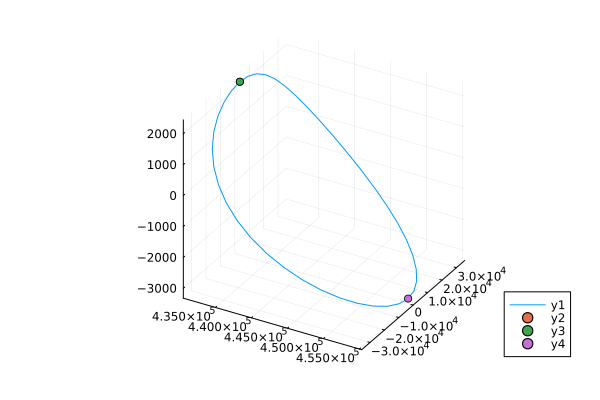

In [188]:
plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])

scatter!([reference_trajectory[1,end]], [reference_trajectory[2,end]], [reference_trajectory[3,end]])

scatter!([reference_trajectory[1,21]], [reference_trajectory[2,21]], [reference_trajectory[3,21]])


#plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

In [189]:
x_initial_ref

6-element Vector{Float64}:
 1.0e-6
 0.0
 0.0
 0.0
 1.0e-6
 0.0

In [190]:
#reference_traj_1 = [reference_trajectory reference_trajectory]

In [191]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.385
 0.0
 0.0
 0.0
 0.08852345449302065
 0.0

In [192]:
N_h

81

In [193]:
#just test to see if it solves

#all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
#all_Bd_1 = cat(all_Bd, all_Bd, dims=3)
bias_0 = zeros(6, N_h-1)

#there was nothing in place for all_Ad_1, maybe a bug? 
display("updating prob")
cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_1, all_Bd_1, V_2orbits, unstable_directions_2, bias_0, reference_trajectory2)
display("solving")
display(X)
Xm, Um = solve_opt(cons, X, U, N_h)

"updating prob"

"solving"

Variable
size: (6, 81)
sign: real
vexity: affine
id: 391…860

([0.385 0.3480556190705536 … 0.5335092169017835 0.6815363544004271; 0.0 -0.01569067367157076 … -0.6201661645440555 -0.7317816455656508; … ; 0.08852345449302065 -0.16489700586728726 … -0.29243335939460824 -0.3095509266735066; 0.0 0.005100037334499592 … 0.029882194814128862 0.03949184359010267], [-0.7912159632933211 -1.7533721918435677e-14 … -1.3643399380632852e-17 4.957007417369687e-18; -0.7455204242052925 -9.092469672123699e-14 … 2.0809495943523918e-17 1.3659551014707362e-12; 3.365370046143939e-12 2.09934505858865e-15 … -5.486803931112998e-19 8.3307429929373e-12])

In [194]:
Um

3×80 Matrix{Float64}:
 -0.791216     -1.75337e-14  -7.77816e-15  …  -1.36434e-17  4.95701e-18
 -0.74552      -9.09247e-14  -5.56664e-14      2.08095e-17  1.36596e-12
  3.36537e-12   2.09935e-15   2.41223e-15     -5.4868e-19   8.33074e-12

In [196]:
#check the constraint

#this is because the constraint is from 2:Nh
constraint_satisfied = zeros(N_h)

for i=1:N_h
    constraint_satisfied[i] = dot(Xm[:,i], unstable_directions_2[:,i])
end

#constraint is not being satisfied... has to do with the cost function. whenever I have a
#tracking cost with a weight of 1e-2 and a control cost with scale 1, it doesn't work. However, 
#when I remove the cost on the controls and make the weight less on the tracking (1e-5) it works (up to the last point)

#with just a tracking cost with a weight of 1e-2 it doesn't satisfy the constraint fully

In [197]:
constraint_satisfied[1]

0.20506152701825905

In [198]:
constraint_satisfied[15]

0.011258397365737294

In [199]:

Xm[:,18]/norm(Xm[:,18])

6-element Vector{Float64}:
  0.4517011408754613
  0.2605902915560844
  0.7622574219968703
 -0.0795748340970117
 -0.2965539357540584
 -0.22966499702048115

In [200]:
unstable_directions[:,18]

6-element Vector{Float64}:
  0.8763990557853825
 -0.253324931452996
 -0.003152202237007567
  0.3829713680353936
 -0.14467125717389165
 -0.01201650351419272

In [201]:
constraint_satisfied[60:70]

11-element Vector{Float64}:
 0.017655819597686064
 0.028280303673084182
 0.026558809906911056
 0.03780365965985942
 0.04017081393836783
 0.05145145625492375
 0.05979789501770283
 0.0719227507469506
 0.08719479776123075
 0.10368782019981661
 0.12581349961239557

In [202]:
constraint_satisfied

81-element Vector{Float64}:
 0.20506152701825905
 0.17670348355242066
 0.1765480236082939
 0.1675262238698479
 0.14984504954385225
 0.12413383746441878
 0.09872038520786337
 0.07133479488905023
 0.04527931999378928
 0.02224099990530392
 ⋮
 0.22350359245550616
 0.27257860878536044
 0.33369655229471784
 0.4085075129242079
 0.5037410261236989
 0.6182899938220434
 0.7630718189195187
 0.9370527136715483
 1.1432736499203064

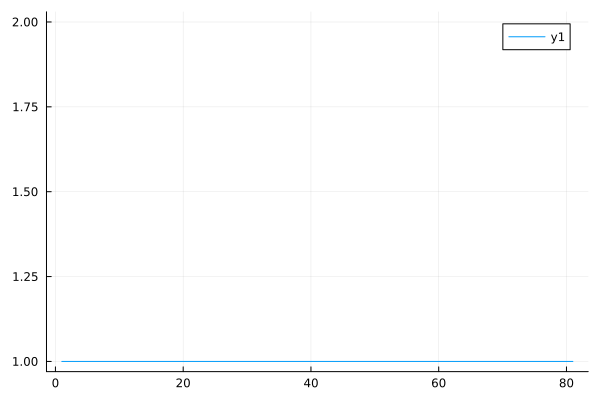

In [203]:
constraint_bool = constraint_satisfied .> 0

plot(constraint_bool)

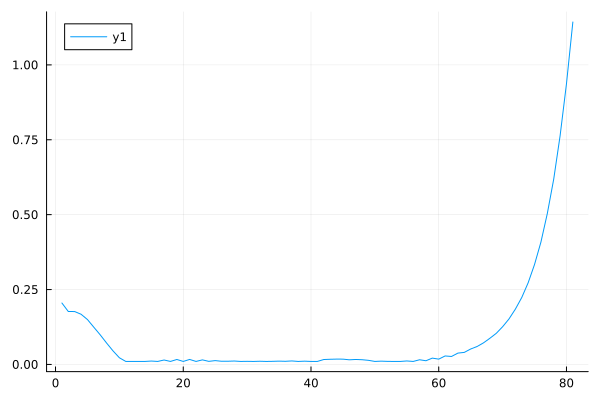

In [204]:
plot(constraint_satisfied)

In [205]:
constraint_satisfied

81-element Vector{Float64}:
 0.20506152701825905
 0.17670348355242066
 0.1765480236082939
 0.1675262238698479
 0.14984504954385225
 0.12413383746441878
 0.09872038520786337
 0.07133479488905023
 0.04527931999378928
 0.02224099990530392
 ⋮
 0.22350359245550616
 0.27257860878536044
 0.33369655229471784
 0.4085075129242079
 0.5037410261236989
 0.6182899938220434
 0.7630718189195187
 0.9370527136715483
 1.1432736499203064

In [206]:
constraint_bool[44]

true

In [207]:
Xm 

6×81 Matrix{Float64}:
 0.385       0.348056      0.280069    …   0.420364    0.533509    0.681536
 0.0        -0.0156907    -0.0674702      -0.515722   -0.620166   -0.731782
 0.0         0.000975594   0.00360825     -0.0239487  -0.0145346  -0.00195469
 0.0        -0.208303     -0.161523        0.260889    0.350542    0.458535
 0.0885235  -0.164897     -0.114888       -0.267151   -0.292433   -0.309551
 0.0         0.00510004    0.00861071  …   0.020694    0.0298822   0.0394918

In [208]:
residual = zeros(6, N_h-1)

6×80 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [209]:
reference_trajectory[:,1]

6-element Vector{Float64}:
 431249.946141646
      0.0
   2286.769716989665
      0.0
  15649.01638927097
      0.0

In [210]:
reference_trajectory[:,end]

6-element Vector{Float64}:
 431249.9493668459
     -0.003851463980650329
   2286.769795836855
      0.002199234649276377
  15649.014948352466
      0.0001293855647662

In [211]:
input = [Xm[:,1] + reference_trajectory[:,1]; Um[:,1]]

9-element Vector{Float64}:
 431250.331141646
      0.0
   2286.769716989665
      0.0
  15649.104912725463
      0.0
     -0.7912159632933211
     -0.7455204242052925
      3.365370046143939e-12

In [212]:
#reference_trajectory2 = [reference_trajectory reference_trajectory]

In [213]:
#find the residual

for k = 1:N_h-1

    input = [Xm[:,k] + reference_trajectory2[:,k]; Um[:,k]]

    xnext_sol = dynamics_wcontrol_integrate(input, Δt)

    residual[:,k] = reference_trajectory2[:,k+1] + Xm[:,k+1] - xnext_sol.u[end][1:6]

end

In [214]:
residual

6×80 Matrix{Float64}:
  7.95041e-6  -1.2322e-6   -1.61643e-7  …  -7.16129e-7  -2.57691e-6
  7.47886e-6   5.0941e-6    1.52272e-6      9.21344e-6   1.3983e-5
  8.51205e-7  -3.21247e-7  -2.12403e-7      1.54379e-7  -9.66079e-8
  2.10788e-5  -2.96096e-6  -2.9284e-6      -7.08997e-7  -8.6909e-7
 -2.12496e-6   6.5355e-7   -8.50932e-7      1.40673e-6   2.51246e-6
  1.00048e-6  -5.18647e-7  -3.67667e-7  …  -5.97655e-7  -7.8173e-7

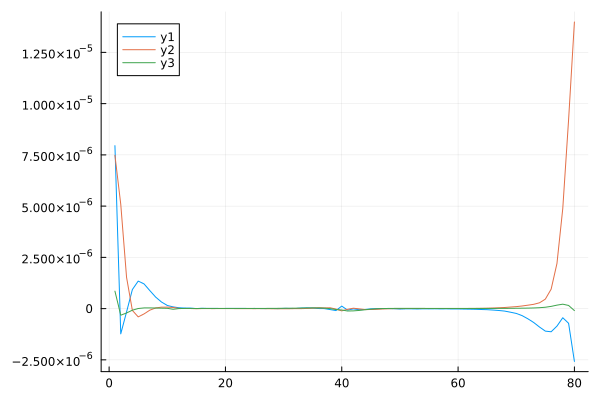

In [215]:
plot(residual[1,:])
plot!(residual[2,:])
plot!(residual[3,:])

In [216]:
#for one period 40 controls
xtraj_test = integrate_oneperiod(Xm[:,1] + reference_trajectory[:,1], Um[:,1:40])

6×41 Matrix{Float64}:
     4.3125e5      4.31267e5      4.31339e5  …  431267.0        4.3125e5
     0.0        5775.2        11343.5            -5775.22      -0.00326739
  2286.77       2237.81        2094.64            2237.79    2286.76
     0.0         101.164        306.421           -101.375     -0.00507064
 15649.1       15364.6        14545.8            15364.7    15649.0
     0.0        -262.02        -504.466      …     262.036      0.0126076

In [217]:
# Xm[:,1]

In [218]:
delta_test = xtraj_test - reference_trajectory

6×41 Matrix{Float64}:
 0.385       0.348048      0.280054    …  -0.0131728   -0.0166387
 0.0        -0.0156982    -0.0674813      -0.00336951   0.000584078
 0.0         0.000974743   0.00360734     -0.0170755   -0.0129683
 0.0        -0.208324     -0.161543       -0.00294847  -0.00726987
 0.0885235  -0.164895     -0.114882        0.012657     0.00553435
 0.0         0.00509904    0.00861018  …   0.0111527    0.0124782

In [219]:
# dot(delta_test[:,1], unstable_directions[:,1])

In [220]:
# delta_test - Xm[:,1:41]

In [221]:
# xtraj_test[:,1] - reference_trajectory[:,1]

In [222]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.385
 0.0
 0.0
 0.0
 0.08852345449302065
 0.0

In [223]:
# delta_test[:,1]

In [224]:
Xm[:,1]

6-element Vector{Float64}:
 0.385
 0.0
 0.0
 0.0
 0.08852345449302065
 0.0

In [225]:
constraint_satisfied_ndynamics = zeros(41)

for i=1:41
    constraint_satisfied_ndynamics[i] = dot(delta_test[:,i], unstable_directions[:,i])
end

In [226]:
# delta_test[:,21]

In [227]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
  0.20506152702378153
  0.17669358637927982
  0.17653446919273474
  0.16750470816213975
  0.14981235198256956
  0.12408801912716518
  0.09866032359764607
  0.07125966377961998
  0.045188256184110626
  0.022132909596846263
  ⋮
  0.005088485299288828
  0.004408984504291873
  0.003774143269650771
  0.0016211761604163853
  0.0008143303231627954
 -0.0032979086597158917
 -0.005501373143172695
 -0.010093230125492238
 -0.01455361654218261

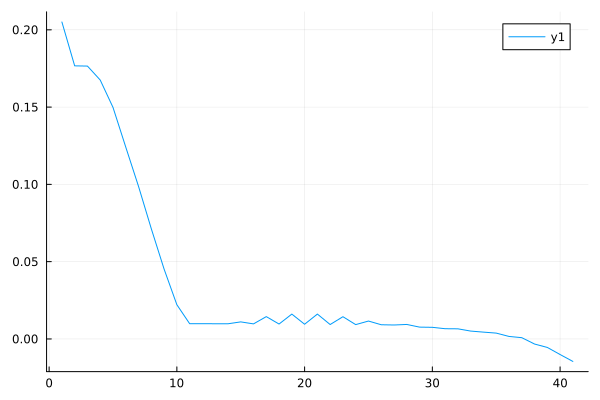

In [228]:
plot(constraint_satisfied_ndynamics)

In [229]:
constraint_satisfied

81-element Vector{Float64}:
 0.20506152701825905
 0.17670348355242066
 0.1765480236082939
 0.1675262238698479
 0.14984504954385225
 0.12413383746441878
 0.09872038520786337
 0.07133479488905023
 0.04527931999378928
 0.02224099990530392
 ⋮
 0.22350359245550616
 0.27257860878536044
 0.33369655229471784
 0.4085075129242079
 0.5037410261236989
 0.6182899938220434
 0.7630718189195187
 0.9370527136715483
 1.1432736499203064

In [230]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
  0.20506152702378153
  0.17669358637927982
  0.17653446919273474
  0.16750470816213975
  0.14981235198256956
  0.12408801912716518
  0.09866032359764607
  0.07125966377961998
  0.045188256184110626
  0.022132909596846263
  ⋮
  0.005088485299288828
  0.004408984504291873
  0.003774143269650771
  0.0016211761604163853
  0.0008143303231627954
 -0.0032979086597158917
 -0.005501373143172695
 -0.010093230125492238
 -0.01455361654218261

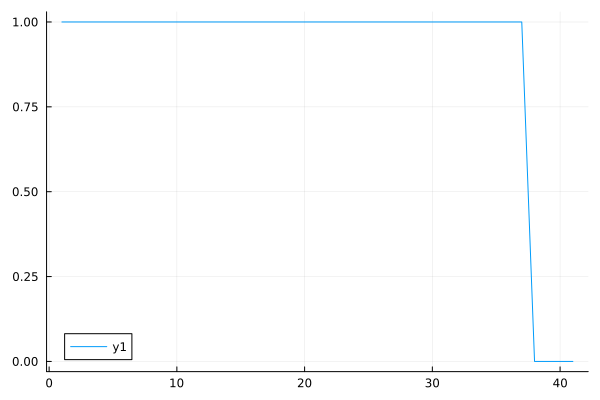

In [231]:
plot(constraint_satisfied_ndynamics .>0)

In [232]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
  0.20506152702378153
  0.17669358637927982
  0.17653446919273474
  0.16750470816213975
  0.14981235198256956
  0.12408801912716518
  0.09866032359764607
  0.07125966377961998
  0.045188256184110626
  0.022132909596846263
  ⋮
  0.005088485299288828
  0.004408984504291873
  0.003774143269650771
  0.0016211761604163853
  0.0008143303231627954
 -0.0032979086597158917
 -0.005501373143172695
 -0.010093230125492238
 -0.01455361654218261

In [233]:
final = Xm + [reference_trajectory reference_trajectory[:,2:end]]

6×81 Matrix{Float64}:
     4.3125e5      4.31267e5      4.31339e5  …      4.31268e5      4.31251e5
     0.0        5775.2        11343.5           -5775.84          -0.735633
  2286.77       2237.81        2094.64           2237.79        2286.77
     0.0         101.164        306.421          -101.022          0.460734
 15649.1       15364.6        14545.8           15364.4        15648.7
     0.0        -262.02        -504.466      …    262.055          0.0396212

In [234]:
residual

6×80 Matrix{Float64}:
  7.95041e-6  -1.2322e-6   -1.61643e-7  …  -7.16129e-7  -2.57691e-6
  7.47886e-6   5.0941e-6    1.52272e-6      9.21344e-6   1.3983e-5
  8.51205e-7  -3.21247e-7  -2.12403e-7      1.54379e-7  -9.66079e-8
  2.10788e-5  -2.96096e-6  -2.9284e-6      -7.08997e-7  -8.6909e-7
 -2.12496e-6   6.5355e-7   -8.50932e-7      1.40673e-6   2.51246e-6
  1.00048e-6  -5.18647e-7  -3.67667e-7  …  -5.97655e-7  -7.8173e-7

In [235]:
#test out the integration function
#xtraj_test = integrate_oneperiod(final[:,1], Um[:,1:39])

In [236]:
#plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

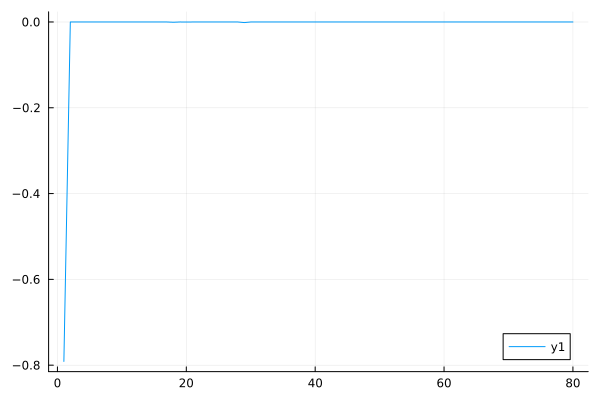

In [237]:
plot(Um[1,:])

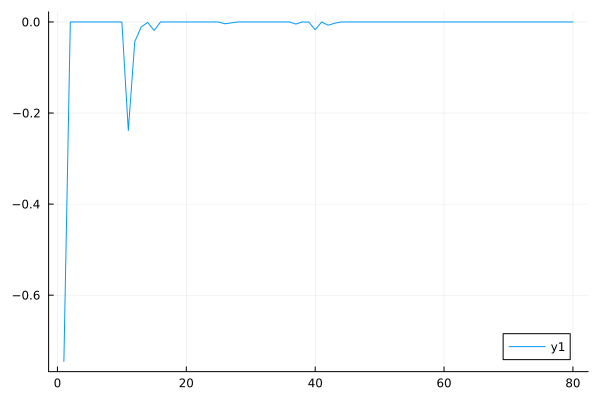

In [238]:
plot(Um[2,:])

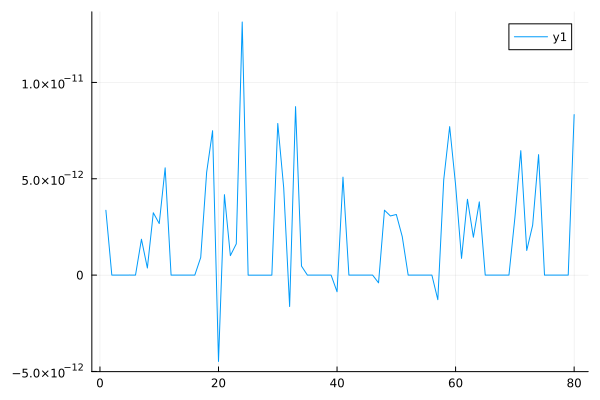

In [239]:
plot(Um[3,:])

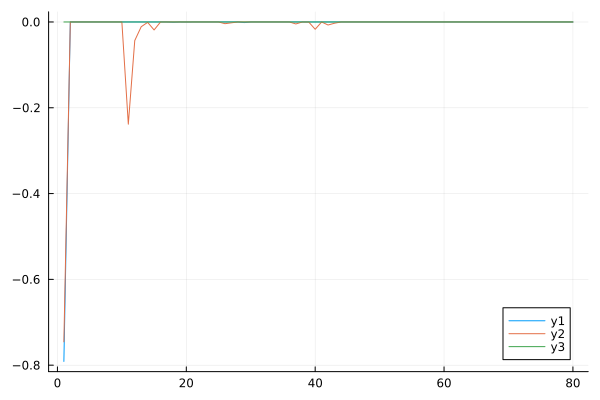

In [240]:
plot(Um[1,:])
plot!(Um[2,:])
plot!(Um[3,:])

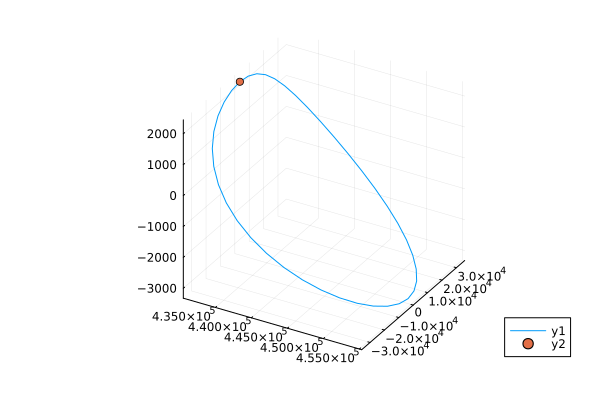

In [241]:
#check out the 1 period solve

#the x trajectory is generated using the linear dynamics
plot(final[1,1:41], final[2,1:41], final[3,1:41])
scatter!([final[1,1]], [final[2,1]], [final[3,1]])

In [242]:
#plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

In [243]:
#xtraj_test - reference_trajectory

In [244]:
#unstable_directions[:,2]

In [245]:
#norm(xtraj_test[:,41] - xtraj_test[:,1])

In [246]:
residual

6×80 Matrix{Float64}:
  7.95041e-6  -1.2322e-6   -1.61643e-7  …  -7.16129e-7  -2.57691e-6
  7.47886e-6   5.0941e-6    1.52272e-6      9.21344e-6   1.3983e-5
  8.51205e-7  -3.21247e-7  -2.12403e-7      1.54379e-7  -9.66079e-8
  2.10788e-5  -2.96096e-6  -2.9284e-6      -7.08997e-7  -8.6909e-7
 -2.12496e-6   6.5355e-7   -8.50932e-7      1.40673e-6   2.51246e-6
  1.00048e-6  -5.18647e-7  -3.67667e-7  …  -5.97655e-7  -7.8173e-7

In [247]:
#solve the problem again and pass in the residual as the bias in the dynamics constraint
display("updating prob")
cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_1, all_Bd_1, V_2orbits, unstable_directions_2, residual, reference_trajectory2)
display("solving")
display(X)
Xm2, Um2 = solve_opt(cons, X, U, N_h)

"updating prob"

"solving"

Variable
size: (6, 81)
sign: real
vexity: affine
id: 682…623

([0.385 0.34805953981400944 … 0.5335252739025506 0.681554470864813; 0.0 -0.015682603321782222 … -0.6201614774869154 -0.7317647707967136; … ; 0.08852345449302065 -0.1648953580548299 … -0.29243678736090434 -0.30955464528269416; 0.0 0.005101019820495347 … 0.029880861385983774 0.03949001635700379], [-0.791274417399568 -1.973148324845301e-14 … -1.581614219643761e-17 4.773472061929533e-18; -0.7455151101215595 -1.0232158527961562e-13 … 2.3041813885987338e-17 6.44479678264269e-12; 1.433408019748588e-11 2.36431605687864e-15 … -5.778219225598316e-19 8.690826866709464e-12])

In [248]:
half_rev_control = Um2[1:3, 1:21]/acceleration_scale

3×21 Matrix{Float64}:
 -3.88751e-5   -9.69402e-19  -4.30086e-19  …  -4.52295e-9   -3.95374e-18
 -3.66269e-5   -5.02703e-18  -3.0785e-18      -1.22195e-15  -2.09428e-15
  7.04229e-16   1.16158e-19   1.33475e-19      8.49481e-16   7.63055e-16

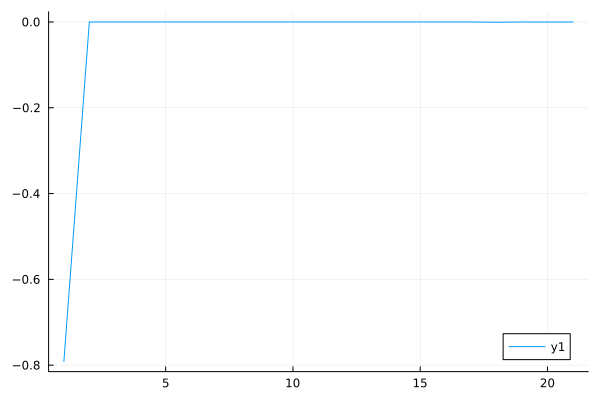

In [250]:
plot(Um2[1,1:21])

In [251]:
Um2[:,1]

3-element Vector{Float64}:
 -0.791274417399568
 -0.7455151101215595
  1.433408019748588e-11

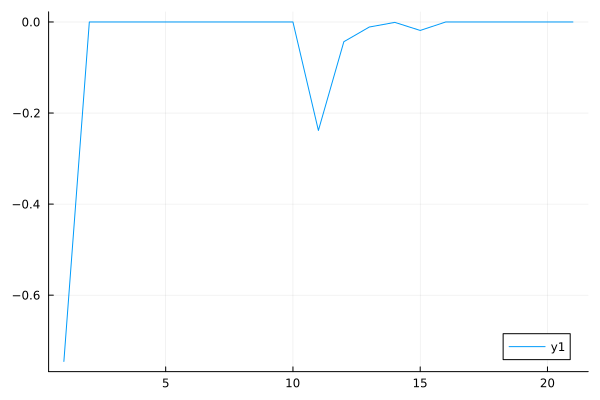

In [252]:
plot(Um2[2,1:21])

In [253]:
#plot(Um2[2,30:40])

In [254]:
#Um2[2, 32]

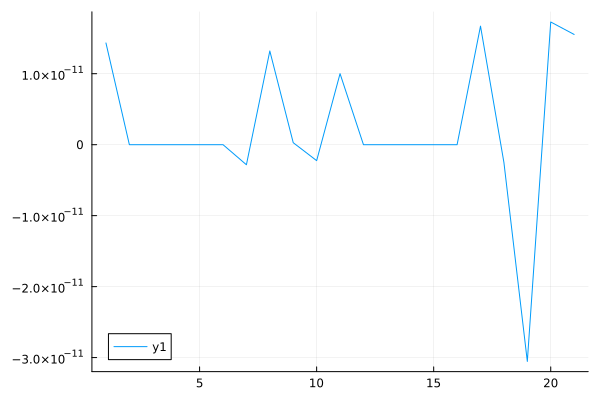

In [255]:
plot(Um2[3,1:21])

In [256]:
#for one period 40 controls
# xtraj_test2 = integrate_oneperiod(Xm2[:,1] + reference_trajectory[:,1], Um2[:,1:40])

In [257]:
# plot(xtraj_test2[1,:], xtraj_test2[2,:], xtraj_test2[3,:])
#scatter!([xtraj_test2[1,1]], [xtraj_test2[2,1]], [xtraj_test2[3,1]])

In [258]:
# xtraj_test2[:,1]

In [259]:
# xtraj_test2[:,41]

In [260]:
#similar to the first solve. No point in doing a second correction
#norm(xtraj_test2[:,1] - xtraj_test2[:,41])

In [261]:
#norm(xtraj_test2[:,41] - reference_trajectory[:,41])

In [262]:
#reference_trajectory[:,41]

In [263]:
#find if the updated solution satisfies the constraints
#delta_test2 = xtraj_test2 - reference_trajectory

In [264]:
#end_state = xtraj_test2[:,21]

#end_state_sim = just_dynamics_integrate(end_state, 2.75*sol_t_final[end])


#end_state_traj = get_state(end_state_sim)

In [265]:
#plot(end_state_traj[1,:],end_state_traj[2,:])
#scatter!([end_state_traj[1,1]],[end_state_traj[2,1]])

In [266]:
# constraint_satisfied_ndynamics2 = zeros(41)

# for i=1:41
#     constraint_satisfied_ndynamics2[i] = dot(delta_test2[:,i], unstable_directions[:,i])
# end

In [267]:
# plot(constraint_satisfied_ndynamics2 .>0)

In [268]:
#fixed the reference trajectory and added some slack on the halfspace constraint and it seems like I don't need to use the second order correction
#anymore

In [269]:
#this initial condition is working
#x_initial_ref = [1e-4, 0, 0, 0, 1e-4, 0]

#x_initial_ref = [1e-6, 0, 0, 0, 1e-6, 0]


#x_initial_ref = [1e-3, 0, 0, 0, 1e-3, 0]

In [270]:
# xposedeviation = x_initial_ref[1] * L*1e3 #in meters

# vyposedeviation = x_initial_ref[5]*V_*1e3 #in m/s

# display(xposedeviation)
# display(vyposedeviation)

In [271]:
#this is one set of jacobians. if starting from beginning 

#all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
#all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

In [272]:
all_Ad[:,:,21:end]

6×6×21 Array{Float64, 3}:
[:, :, 1] =
  1.02013      -0.000709133  -0.00082352   …   0.031622    -0.000101849
 -0.00159494    0.995426      6.51496e-5       0.368931     7.7217e-6
 -0.000826291   1.81356e-5    0.991778        -9.85875e-7   0.370285
  0.108365     -0.0057235    -0.00442342       0.169911    -0.000820395
 -0.0128926    -0.0243841     0.000525395      0.980834     8.3054e-5
 -0.00445321    0.000146447  -0.0442353    …  -1.07577e-5   0.991774

[:, :, 2] =
  1.01995      -0.00203182   -0.000808748  …  0.0314582   -9.98284e-5
 -0.00291862    0.995629      0.000117715     0.368949     1.41869e-5
 -0.000814518   7.14332e-5    0.991758        5.62796e-6   0.370282
  0.107069     -0.0127966    -0.00432351      0.168593    -0.000801069
 -0.0199745    -0.0229568     0.000803244     0.98101      0.00013438
 -0.00437718    0.000431073  -0.044365     …  4.23675e-5   0.991746

[:, :, 3] =
  1.01965      -0.00330381   -0.000780747  …  0.0313003  -9.61858e-5
 -0.00419301    0.995971    

In [273]:
all_Ad_half = cat(all_Ad[:,:,21:end], all_Ad[:,:,2:21], dims=3)
all_Bd_half = cat(all_Bd[:,:,21:end], all_Bd[:,:,2:21], dims=3)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
  0.0689975    0.0039157   -9.47389e-6
 -0.00393117   0.0687129    3.13362e-7
 -9.47389e-6   3.13362e-7   0.0688387
  0.371993     0.0315803   -0.000101556
 -0.0318296    0.36893      9.38114e-6
 -0.000101985  6.98529e-7   0.370284

[:, :, 2] =
  0.068996     0.00390048  -9.31221e-6
 -0.00394639   0.0687147    9.19497e-7
 -9.31221e-6   9.19497e-7   0.0688384
  0.371973     0.0314174   -9.91153e-5
 -0.0319928    0.368953     1.57214e-5
 -0.000100092  7.2234e-6    0.37028

[:, :, 3] =
  0.0689933   0.00388581  -8.9976e-6
 -0.00396106  0.068718     1.47281e-6
 -8.9976e-6   1.47281e-6   0.0688378
  0.371941    0.0312614   -9.50906e-5
 -0.0321494   0.368993     2.13371e-5
 -9.6559e-5   1.3161e-5    0.370273

;;; … 

[:, :, 39] =
  0.068996      0.00394633  -9.31194e-6
 -0.00390054    0.0687147   -9.17085e-7
 -9.31194e-6   -9.17085e-7   0.0688384
  0.371985      0.0319116   -0.000101251
 -0.0314984     0.368939    -4.0069e-6
 -0.000100543  -1.26151e-5   

In [274]:
all_Ad_2 = cat(all_Ad_half, all_Ad_half[:,:,2:end], dims = 3)
all_Bd_2 = cat(all_Bd_half, all_Bd_half[:,:,2:end], dims=3)

6×3×81 Array{Float64, 3}:
[:, :, 1] =
  0.0689975    0.0039157   -9.47389e-6
 -0.00393117   0.0687129    3.13362e-7
 -9.47389e-6   3.13362e-7   0.0688387
  0.371993     0.0315803   -0.000101556
 -0.0318296    0.36893      9.38114e-6
 -0.000101985  6.98529e-7   0.370284

[:, :, 2] =
  0.068996     0.00390048  -9.31221e-6
 -0.00394639   0.0687147    9.19497e-7
 -9.31221e-6   9.19497e-7   0.0688384
  0.371973     0.0314174   -9.91153e-5
 -0.0319928    0.368953     1.57214e-5
 -0.000100092  7.2234e-6    0.37028

[:, :, 3] =
  0.0689933   0.00388581  -8.9976e-6
 -0.00396106  0.068718     1.47281e-6
 -8.9976e-6   1.47281e-6   0.0688378
  0.371941    0.0312614   -9.50906e-5
 -0.0321494   0.368993     2.13371e-5
 -9.6559e-5   1.3161e-5    0.370273

;;; … 

[:, :, 79] =
  0.068996      0.00394633  -9.31194e-6
 -0.00390054    0.0687147   -9.17085e-7
 -9.31194e-6   -9.17085e-7   0.0688384
  0.371985      0.0319116   -0.000101251
 -0.0314984     0.368939    -4.0069e-6
 -0.000100543  -1.26151e-5   

In [275]:
#another set of jacobians if starting from half

#all_Ad_half = cat(all_Ad[:,:,21:end], all_Ad[:,:,1:20], dims=3)
#all_Bd_half = cat(all_Bd[:,:,21:end], all_Bd[:,:,1:20], dims=3)

#all_Ad_2 = cat(all_Ad_half, all_Ad_half, dims=3)
#all_Bd_2 = cat(all_Bd_half, all_Bd_half, dims=3)

#All Ad1 is if you start from the beginning (2 orbits worth of jacobians) and all_Ad_2 is if you start from the half (2 orbits worth of jacobians).
#need to also have two sets of cost to go and unstable direction matrices that we pass in in the update_prob function 

In [276]:
#unstable directions is good. Need to fix V_2orbits
unstable_directions_half = cat(unstable_directions[:,21:end], unstable_directions[:,2:21], dims=2)

#P is for the 16 orbits. Need the one for just 1 orbit
V_half = cat(V[:,:,21:end], V[:,:,2:21], dims=3)


#unstable directions if you start from the beginning
unstable_directions_2_1 = unstable_directions_2
#this is the unstable direction if you start at the half
unstable_directions_2_2 = cat(unstable_directions_half, unstable_directions_half[:,2:end], dims=2)


#cost to go if you start from the beginning
V_2orbits_1 = V_2orbits

#cost to go in you start at the half
V_2orbits_2 = cat(V_half, V_half[:,:,2:end], dims=3)

6×6×81 Array{Float64, 3}:
[:, :, 1] =
  772.894   -287.342    -22.3345    1291.56     457.86    -21.3223
 -287.342    106.992      8.35038   -479.972   -170.378     7.59879
  -22.3345     8.35038    0.921632   -37.3474   -13.2516   -0.988615
 1291.56    -479.972    -37.3474    2160.83     760.832   -35.0727
  457.86    -170.378    -13.2516     760.832    278.841   -12.9023
  -21.3223     7.59879   -0.988615   -35.0727   -12.9023   16.147

[:, :, 2] =
  750.793   -317.889    -20.813     1278.42     417.519    -16.0992
 -317.889    134.751      8.84188   -541.27    -176.63       6.4716
  -20.813      8.84188    0.737205   -35.4355   -11.6217    -0.523835
 1278.42    -541.27     -35.4355    2178.83     706.937    -26.9208
  417.519   -176.63     -11.6217     706.937    240.677     -9.17271
  -16.0992     6.4716    -0.523835   -26.9208    -9.17271   16.901

[:, :, 3] =
  729.762   -344.647    -19.0513     1263.51     384.303    -10.6507
 -344.647    162.942      9.00808    -596.833   -181.

In [277]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.385
 0.0
 0.0
 0.0
 0.08852345449302065
 0.0

In [278]:
unstable_directions_2[:,1]

6-element Vector{Float64}:
  0.5935997677778412
 -0.642321538347488
  0.013967734765510598
  0.4049742470161906
 -0.26517699417232504
  0.02332981932914014

In [279]:
#pseudo code

orbit_count = 0
orbits = true

#number of orbits you want to plan go for
orbit_num = 100

halforbit_num = orbit_num*2 

#this is for each orbit plan

optimal_Δx = zeros(nx, N_period)
optimal_u = zeros(nu, N_period-1)

#data for all the orbits
all_optimal_Δx = zeros(nx, 21, halforbit_num)
all_optimal_x = zeros(nx, 21, halforbit_num)
all_optimal_u = zeros(nu, 20, halforbit_num)

solution_xm = zeros(6, 81, halforbit_num)
solution_um = zeros(6, 80, halforbit_num)

#optimal_Δx[:,1] = x_initial_ref


#while orbits
    
#    orbits=false
    
#for i=1:N_period-1
 
#i is now the number of times it orbits
for i=1:halforbit_num

        
    #Ad_k = cat(all_Ad_3p[:,:,i:end],all_Ad_3p[:,:,1:(i-1)], dims=3)
    #Bd_k = cat(all_Bd_3p[:,:,i:end],all_Bd_3p[:,:,1:(i-1)], dims=3)
    
    #Ad_k = cat(all_Ad[:,:,i:end],all_Ad[:,:,1:(i-1)], dims=3)
    #Bd_k = cat(all_Bd[:,:,i:end],all_Bd[:,:,1:(i-1)], dims=3)
    
    #Ad_k = all_Ad_3p[:,:,1:N_h]
    #Bd_k = all_Bd_3p[:,:,1:N_h]
      
    #horizon is two orbits ahead
    #all_Ad_k = cat(Ad_k, Ad_k, dims=3)
    #all_Bd_k = cat(Bd_k, Bd_k, dims=3)
        
    #cons, X, U = update_prob(optimal_Δx[:,i], all_Ad_k, all_Bd_k)
    
    #if you start from the beginning use the appropriate set of jacobians
    if i%2 != 0
        #println("using jacobian 1")
        all_Ad_k = all_Ad_1
        all_Bd_k = all_Bd_1
        unstable_directions_k = unstable_directions_2_1
        P_k = V_2orbits_1 
        reference_traj_k = reference_trajectory2       
    else
        #println("using jacobian 2")
        all_Ad_k = all_Ad_2
        all_Bd_k = all_Bd_2
        unstable_directions_k = unstable_directions_2_2
        P_k = V_2orbits_2
        reference_traj_k = reference_trajectory2_2
    end
    Δt
    #the zeros is the bias 
    cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_k, all_Bd_k, P_k, unstable_directions_k, zeros(6, N_h-1), reference_traj_k)
        
    Xm, Um = solve_opt(cons, X, U,N_h)

    solution_xm = Xm
    solution_um = Um
    
    #get the optimal controls for half a period (20 for this example)
        
    optimal_u = Um[:,1:20]
        
    #size N_period
        
    orbit_count += 1
    
    #rollout on the nonlinear dynamics
    if i%2 != 0
        
        #print("from beginning")
        
        xtraj_halfperiod = integrate_halfperiod(reference_trajectory[:,1] + Xm[:,1], optimal_u)

        #this is the deviation from the reference
        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,1:21]
        
        #integrate the initial condition by all the optimal controls from the solver        
    else
        
        #print("this is reference trajectory at half: ", reference_trajectory[:,21])
        #println("from half")
        xtraj_halfperiod = integrate_halfperiod(reference_trajectory[:,21] + Xm[:,1], optimal_u)

        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,21:41] 
        #integrate the initial condition by all the optimal controls from the solver
        
    end
    
    all_optimal_x[:,:,orbit_count] = xtraj_halfperiod
    
    all_optimal_u[:,:,orbit_count] = optimal_u
    
    println("Half Revolution solved: ", i)
    
    #update the intiial condition for the next rev (has to be a delta)
    x_initial_ref_scaled = all_optimal_Δx[:,end, orbit_count]

    #println("this is the initial condition for the next rev: ", x_initial_ref)
    
end  

Half Revolution solved: 1
Half Revolution solved: 2
Half Revolution solved: 3
Half Revolution solved: 4
Half Revolution solved: 5
Half Revolution solved: 6
Half Revolution solved: 7
Half Revolution solved: 8
Half Revolution solved: 9
Half Revolution solved: 10
Half Revolution solved: 11
Half Revolution solved: 12
Half Revolution solved: 13
Half Revolution solved: 14
Half Revolution solved: 15
Half Revolution solved: 16
Half Revolution solved: 17
Half Revolution solved: 18
Half Revolution solved: 19
Half Revolution solved: 20
Half Revolution solved: 21
Half Revolution solved: 22
Half Revolution solved: 23
Half Revolution solved: 24
Half Revolution solved: 25
Half Revolution solved: 26
Half Revolution solved: 27
Half Revolution solved: 28
Half Revolution solved: 29
Half Revolution solved: 30
Half Revolution solved: 31
Half Revolution solved: 32
Half Revolution solved: 33
Half Revolution solved: 34
Half Revolution solved: 35
Half Revolution solved: 36
Half Revolution solved: 37
Half Revol

In [280]:
#the current problem is that the linear problem does satisfy the dynamics, however, the nonlinear rollout breaks those dynamics. need second order
# correction for the MPC problem. FIXED 

In [281]:
all_optimal_Δx

6×21×200 Array{Float64, 3}:
[:, :, 1] =
 0.385       0.348048      0.280054    …   0.0113054    0.0173457
 0.0        -0.0156982    -0.0674813       0.00179102  -0.000902928
 0.0         0.000974743   0.00360734      0.0165336    0.0129214
 0.0        -0.208324     -0.161543       -0.0029354   -0.00319429
 0.0885235  -0.164895     -0.114882       -0.00781359  -0.0110291
 0.0         0.00509904    0.00861018  …  -0.00854774  -0.00925431

[:, :, 2] =
  0.0173457     0.00950092   0.0137633   …  -0.00249844  -0.00303682
 -0.000902928  -0.00393525  -0.00894347     -0.0181409   -0.0172867
  0.0129214     0.00966022   0.00569894     -0.016919    -0.012645
 -0.00319429   -0.00301874  -0.00498743      0.00412069   0.00166123
 -0.0110291    -0.00813592  -0.0102704       0.0011905    0.000378821
 -0.00925431   -0.00980075  -0.0101678   …   0.0115266    0.0130039

[:, :, 3] =
 -0.00303682   -0.00171989   0.0002211   …   0.00521452   0.0116425
 -0.0172867    -0.01694     -0.0161405      -0.0208501 

In [282]:
dot(all_optimal_Δx[:,end,1], unstable_directions_2[:,21])

0.016081962146733825

In [283]:
dot(all_optimal_Δx[:,end,2], unstable_directions_2[:,1])

0.0100000474731884

In [284]:
#dot(acceleration_scale[:,end,2], unstable_directions_2_2[:,21])

In [285]:
solution_xm

6×81 Matrix{Float64}:
  0.0201566     0.0134093   …   0.652208    0.758654     0.897736
 -0.00712953   -0.00921108     -0.174203   -0.230701    -0.301106
  0.337638      0.335567        0.318501    0.323609     0.321566
  0.000437021  -0.00074173      0.283497    0.328686     0.383059
 -0.00791415   -0.00608439     -0.128807   -0.165334    -0.220369
  0.00117588   -0.0138366   …   0.0214993   0.00424114  -0.0137111

In [286]:
unstable_directions_2_2

6×81 Matrix{Float64}:
  0.853424    0.842303    0.82924    …   0.870363    0.862736    0.853424
 -0.304033   -0.328043   -0.355046      -0.266419   -0.283396   -0.304033
 -0.0138024  -0.016739   -0.0193182     -0.0069715  -0.0105353  -0.0138024
  0.371324    0.364042    0.354823       0.380529    0.37675     0.371324
 -0.202336   -0.223322   -0.244513      -0.162681   -0.181998   -0.202336
 -0.014817   -0.0153188  -0.015594   …  -0.0131574  -0.0140939  -0.014817

In [287]:
xtraj_halfperiod_test = integrate_halfperiod(reference_trajectory[:,21] + solution_xm[:,1], optimal_u)

6×21 Matrix{Float64}:
      4.5462e5          4.54408e5  453783.0    …  431267.0    431250.0
     -0.00708567    -5115.63       -10112.2        -5775.23       -0.0161854
  -3157.7           -3131.63        -3053.79        2237.57     2286.53
      0.000467074   -1134.14        -2222.82        -101.367       0.00373324
 -13831.2          -13670.2        -13191.5        15364.7     15649.0
      0.00117544      140.251         278.572  …     261.995      -0.00143153

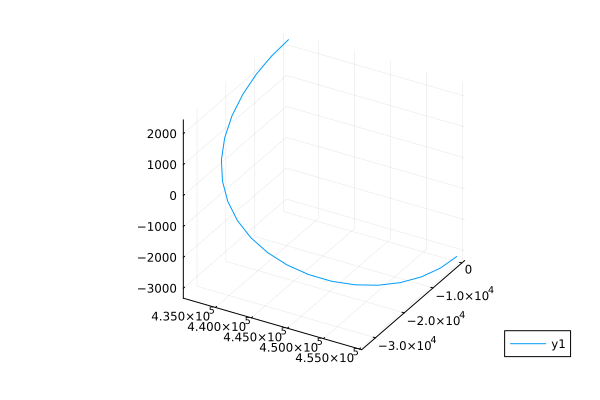

In [289]:
plot(xtraj_halfperiod_test[1,:],xtraj_halfperiod_test[2,:], xtraj_halfperiod_test[3,:])

In [290]:
test_deltas = xtraj_halfperiod_test - reference_trajectory[:,21:end]

6×21 Matrix{Float64}:
  0.0201566     0.0134094     0.0184065   …   0.00754613   0.00714865
 -0.00712953   -0.0092111    -0.0134851      -0.0127433   -0.0123339
  0.337638      0.335567      0.327421       -0.238504    -0.244565
  0.000437021  -0.000741645  -0.00328408      0.00490498   0.001534
 -0.00791415   -0.00608441   -0.00834647      0.00177516  -0.0025714
  0.00117588   -0.0138365    -0.0286503   …  -0.0293      -0.00156091

In [291]:
test_deltas - solution_xm[:,1:21]

6×21 Matrix{Float64}:
 0.0   2.10864e-8   6.5202e-8    1.3311e-7   …   7.14306e-6   9.35352e-6
 0.0  -2.35872e-8  -5.752e-8    -1.02122e-7     -9.04909e-6  -1.0678e-5
 0.0  -3.99391e-9  -3.29039e-9   2.40962e-9     -5.95495e-7   3.37474e-7
 0.0   8.59115e-8   1.68065e-7   2.40698e-7      5.08998e-6   6.8923e-6
 0.0  -2.83164e-8  -5.55718e-8  -9.83354e-8     -4.07601e-6  -4.31616e-6
 0.0   1.56434e-8   2.59744e-8   3.59665e-8  …   3.33129e-6   4.00947e-6

In [292]:
#linear problem is good
solution_xm[:, 1:21]

6×21 Matrix{Float64}:
  0.0201566     0.0134093    0.0184065   …   0.00753899   0.0071393
 -0.00712953   -0.00921108  -0.013485       -0.0127342   -0.0123232
  0.337638      0.335567     0.327421       -0.238503    -0.244565
  0.000437021  -0.00074173  -0.00328425      0.00489989   0.00152711
 -0.00791415   -0.00608439  -0.00834642      0.00177924  -0.00256708
  0.00117588   -0.0138366   -0.0286503   …  -0.0293033   -0.00156492

In [293]:
#linear problem is good and solves
test = zeros(21)

for k=1:21
    test[k] = dot(test_deltas[:,k], unstable_directions_2_2[:,k])

end


In [294]:
test

21-element Vector{Float64}:
 0.016455687617397612
 0.010000065172145786
 0.015048408335655569
 0.010000255364567247
 0.012323887044523144
 0.010212119577368384
 0.010032106337579588
 0.010771861532042407
 0.01000130682542626
 0.01003057162810175
 ⋮
 0.010282457025715758
 0.011038286742894077
 0.012121893874487623
 0.011958056720308793
 0.013407105163343855
 0.011044942222066862
 0.011485436126188008
 0.011552417941103897
 0.010016444796601263

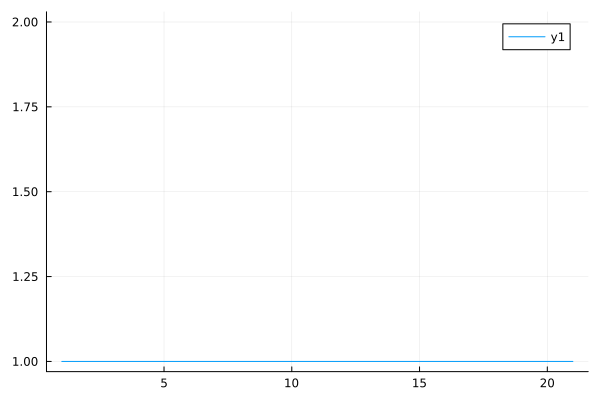

In [295]:
plot(test .>0)

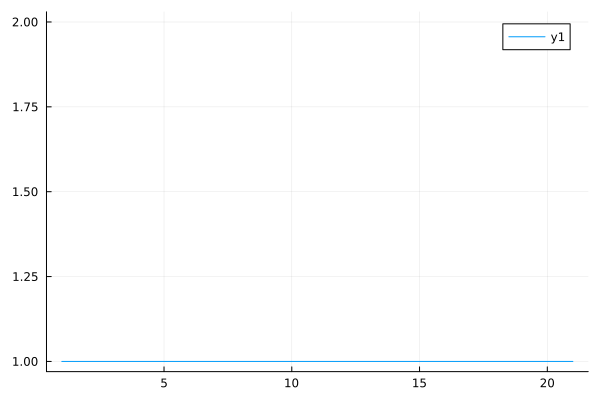

In [296]:
plot(test.>0)

In [298]:
rev1 = all_optimal_x[:,:,1]
rev2 = all_optimal_x[:,:,2]
rev3 = all_optimal_x[:,:,3]
rev4 = all_optimal_x[:,:,4]
rev5 = all_optimal_x[:,:,5]
# rev20 = all_optimal_x[:,:,20]

# rev59 = all_optimal_x[:,:,59]
# rev60 = all_optimal_x[:,:,60]
#rev25 = all_optimal_x[:,:,25]

6×21 Matrix{Float64}:
     4.3125e5    431267.0    …       4.54408e5       4.5462e5
    -0.0176256     5775.2         5115.6            -0.0214751
  2286.75          2237.79       -3131.94        -3158.01
     0.00208738     101.378       1134.14           -0.00213879
 15649.0          15364.7       -13670.2        -13831.2
     0.0129424     -262.01   …    -140.273          -0.00925699

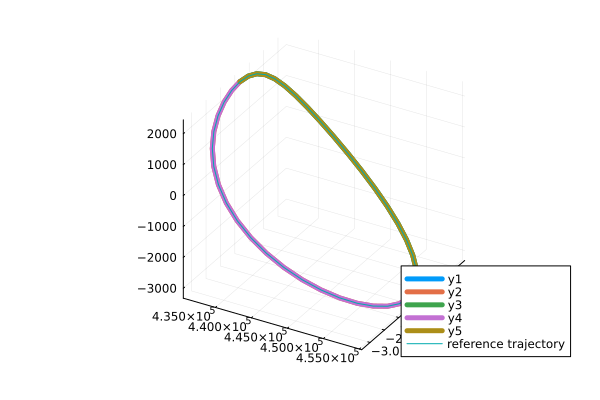

In [299]:
plot(rev1[1,:], rev1[2,:], rev1[3,:], lw=5)
#scatter!([rev1[1,1]],[rev1[2,1]],[rev1[3,1]], lw=5)
plot!(rev2[1,:], rev2[2,:], rev2[3,:], lw=5)
plot!(rev3[1,:], rev3[2,:], rev3[3,:], lw=5)
plot!(rev4[1,:], rev4[2,:], rev4[3,:], lw=5)
plot!(rev5[1,:], rev5[2,:], rev5[3,:], lw=5)
#plot!(rev59[1,:], rev59[2,:], rev59[3,:], lw=5)
#plot!(rev60[1,:], rev60[2,:], rev60[3,:], lw=5)

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="reference trajectory")

#scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])

In [300]:
1e-3*L

385.0

In [301]:
all_optimal_x_formatted = zeros(6, N_period, orbit_num)
all_optimal_Δx_formatted = zeros(6, N_period, orbit_num)

6×41×100 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] 

In [302]:
#have orbit_num trajectories of N knot points

for i=1:orbit_num
    
    all_optimal_x_formatted[:,1:21,i] = all_optimal_x[:,:,(2*i-1)]
    
    #2:end is used to not repeat the same element twice
    all_optimal_x_formatted[:,22:end,i] = all_optimal_x[:,2:end,(2*i)]
    
    
    all_optimal_Δx_formatted[:,1:21,i] = all_optimal_Δx[:,:,(2*i-1)]
    
    all_optimal_Δx_formatted[:,22:end,i] = all_optimal_Δx[:,2:end,(2*i)]
    
end

In [303]:
all_optimal_x

6×21×200 Array{Float64, 3}:
[:, :, 1] =
     4.3125e5      4.31267e5  …       4.54408e5       4.5462e5
     0.0        5775.2             5115.62           -0.00085907
  2286.77       2237.81           -3131.95        -3158.03
     0.0         101.164           1134.14           -0.00316424
 15649.1       15364.6           -13670.2        -13831.2
     0.0        -262.02       …    -140.274          -0.00925475

[:, :, 2] =
      4.5462e5         4.54408e5  453783.0    …  431267.0        4.3125e5
     -0.00085907   -5115.63       -10112.2        -5775.23      -0.0211382
  -3158.03         -3131.96        -3054.11        2237.79    2286.76
     -0.00316424   -1134.15        -2222.82        -101.368      0.00386046
 -13831.2         -13670.2        -13191.5        15364.7    15649.0
     -0.00925475     140.255         278.591  …     262.036      0.0131333

[:, :, 3] =
     4.3125e5    431267.0    …       4.54408e5       4.5462e5
    -0.0172867     5775.2         5115.6            -0.021

In [304]:
all_optimal_x_formatted

6×41×100 Array{Float64, 3}:
[:, :, 1] =
     4.3125e5      4.31267e5      4.31339e5  …  431267.0        4.3125e5
     0.0        5775.2        11343.5            -5775.23      -0.0211382
  2286.77       2237.81        2094.64            2237.79    2286.76
     0.0         101.164        306.421           -101.368      0.00386046
 15649.1       15364.6        14545.8            15364.7    15649.0
     0.0        -262.02        -504.466      …     262.036      0.0131333

[:, :, 2] =
     4.3125e5    431267.0        4.31338e5  …  431267.0        4.3125e5
    -0.0172867     5775.2    11343.6            -5775.24      -0.0214771
  2286.76          2237.8     2094.63            2237.78    2286.75
     0.00166123     101.378    306.587           -101.368      0.00428661
 15649.0          15364.7    14545.9            15364.7    15649.0
     0.0130039     -262.011   -504.46       …     262.036      0.0130718

[:, :, 3] =
     4.3125e5    431267.0        4.31338e5  …  431267.0        4.3125e5
  

In [305]:
all_xtraj = reshape(all_optimal_x_formatted, (6, N_period*orbit_num))

all_Δxtraj = reshape(all_optimal_Δx_formatted, (6, N_period*orbit_num))
#all_xtraj = reshape(all_optimal_x, (6, 210))

6×4100 Matrix{Float64}:
 0.385       0.348048      0.280054    …   0.00754613   0.00714865
 0.0        -0.0156982    -0.0674813      -0.0127433   -0.0123339
 0.0         0.000974743   0.00360734     -0.238504    -0.244565
 0.0        -0.208324     -0.161543        0.00490498   0.001534
 0.0885235  -0.164895     -0.114882        0.00177516  -0.0025714
 0.0         0.00509904    0.00861018  …  -0.0293      -0.00156091

In [306]:
normz = zeros(4100)

4100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [307]:
for i=1:4100
    normz[i] = norm(all_Δxtraj[:,i])
end

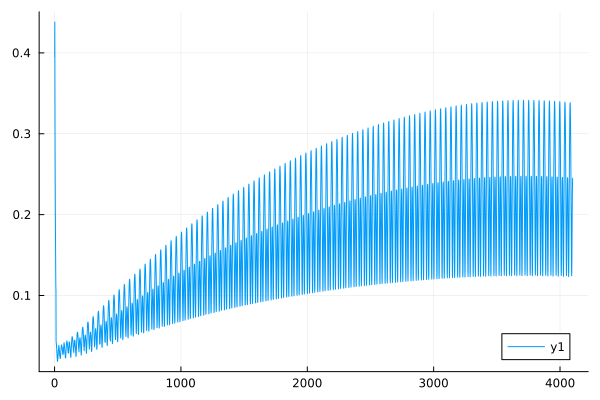

In [308]:
plot(normz )

In [309]:
all_xtraj 

6×4100 Matrix{Float64}:
     4.3125e5      4.31267e5      4.31339e5  …  431267.0    431250.0
     0.0        5775.2        11343.5            -5775.23       -0.0161854
  2286.77       2237.81        2094.64            2237.57     2286.53
     0.0         101.164        306.421           -101.367       0.00373324
 15649.1       15364.6        14545.8            15364.7     15649.0
     0.0        -262.02        -504.466      …     261.995      -0.00143153

In [310]:
for i=1:100
    deltaxsub = all_Δxtraj[41*(i-1)+1:41*i]

    for i=1:41
        plot(deltaxsub[1,:], deltaxsub[2,:], deltaxsub[3,:], lw=5)
    end
end

In [311]:
all_optimal_u

3×20×200 Array{Float64, 3}:
[:, :, 1] =
 -0.791216     -1.75337e-14  -7.77816e-15  …  -1.05701e-13  -9.16314e-5
 -0.74552      -9.09247e-14  -5.56664e-14      1.25376e-11  -2.54559e-11
  3.36537e-12   2.09935e-15   2.41223e-15      7.49559e-12  -4.47926e-12

[:, :, 2] =
  0.00198014    4.22685e-14  -2.94118e-12  …  -1.18041e-11  -9.17015e-12
 -0.00318442   -3.42503e-11  -5.99605e-11     -0.0141261    -2.35738e-9
 -9.84687e-12  -1.16793e-11  -9.10006e-12      2.46266e-12   3.57672e-12

[:, :, 3] =
 0.0125798     9.97045e-11   4.81177e-11  …  -1.15396e-10  -0.000693503
 4.39898e-12  -5.05298e-11  -9.97524e-11     -5.0195e-5    -3.5088e-10
 2.02074e-11   9.56602e-12   9.99063e-12     -4.63289e-11   5.41365e-11

;;; … 

[:, :, 198] =
 -2.67111e-12  -3.28072e-5   -2.6311e-11   …  -4.93625e-13  -3.76856e-13
 -0.00516624   -7.48615e-12   9.03366e-12     -0.0100193    -0.00834094
  7.31902e-12   4.06485e-12   4.01437e-13      1.22247e-13   5.05388e-12

[:, :, 199] =
  0.0125272     7.15637e-12

In [312]:
all_optimal_u

3×20×200 Array{Float64, 3}:
[:, :, 1] =
 -0.791216     -1.75337e-14  -7.77816e-15  …  -1.05701e-13  -9.16314e-5
 -0.74552      -9.09247e-14  -5.56664e-14      1.25376e-11  -2.54559e-11
  3.36537e-12   2.09935e-15   2.41223e-15      7.49559e-12  -4.47926e-12

[:, :, 2] =
  0.00198014    4.22685e-14  -2.94118e-12  …  -1.18041e-11  -9.17015e-12
 -0.00318442   -3.42503e-11  -5.99605e-11     -0.0141261    -2.35738e-9
 -9.84687e-12  -1.16793e-11  -9.10006e-12      2.46266e-12   3.57672e-12

[:, :, 3] =
 0.0125798     9.97045e-11   4.81177e-11  …  -1.15396e-10  -0.000693503
 4.39898e-12  -5.05298e-11  -9.97524e-11     -5.0195e-5    -3.5088e-10
 2.02074e-11   9.56602e-12   9.99063e-12     -4.63289e-11   5.41365e-11

;;; … 

[:, :, 198] =
 -2.67111e-12  -3.28072e-5   -2.6311e-11   …  -4.93625e-13  -3.76856e-13
 -0.00516624   -7.48615e-12   9.03366e-12     -0.0100193    -0.00834094
  7.31902e-12   4.06485e-12   4.01437e-13      1.22247e-13   5.05388e-12

[:, :, 199] =
  0.0125272     7.15637e-12

In [313]:
all_optimal_u 

3×20×200 Array{Float64, 3}:
[:, :, 1] =
 -0.791216     -1.75337e-14  -7.77816e-15  …  -1.05701e-13  -9.16314e-5
 -0.74552      -9.09247e-14  -5.56664e-14      1.25376e-11  -2.54559e-11
  3.36537e-12   2.09935e-15   2.41223e-15      7.49559e-12  -4.47926e-12

[:, :, 2] =
  0.00198014    4.22685e-14  -2.94118e-12  …  -1.18041e-11  -9.17015e-12
 -0.00318442   -3.42503e-11  -5.99605e-11     -0.0141261    -2.35738e-9
 -9.84687e-12  -1.16793e-11  -9.10006e-12      2.46266e-12   3.57672e-12

[:, :, 3] =
 0.0125798     9.97045e-11   4.81177e-11  …  -1.15396e-10  -0.000693503
 4.39898e-12  -5.05298e-11  -9.97524e-11     -5.0195e-5    -3.5088e-10
 2.02074e-11   9.56602e-12   9.99063e-12     -4.63289e-11   5.41365e-11

;;; … 

[:, :, 198] =
 -2.67111e-12  -3.28072e-5   -2.6311e-11   …  -4.93625e-13  -3.76856e-13
 -0.00516624   -7.48615e-12   9.03366e-12     -0.0100193    -0.00834094
  7.31902e-12   4.06485e-12   4.01437e-13      1.22247e-13   5.05388e-12

[:, :, 199] =
  0.0125272     7.15637e-12

In [314]:
all_utraj = reshape(all_optimal_u, (3, (N_period-1)*orbit_num))

3×4000 Matrix{Float64}:
 -0.791216     -1.75337e-14  -7.77816e-15  …  -3.38245e-13  -2.58154e-13
 -0.74552      -9.09247e-14  -5.56664e-14     -0.0103385    -0.00799113
  3.36537e-12   2.09935e-15   2.41223e-15      8.52505e-14   1.91688e-12

In [315]:
all_utraj

3×4000 Matrix{Float64}:
 -0.791216     -1.75337e-14  -7.77816e-15  …  -3.38245e-13  -2.58154e-13
 -0.74552      -9.09247e-14  -5.56664e-14     -0.0103385    -0.00799113
  3.36537e-12   2.09935e-15   2.41223e-15      8.52505e-14   1.91688e-12

In [316]:
all_utraj_scaled = all_utraj/acceleration_scale

3×4000 Matrix{Float64}:
 -3.88722e-5  -8.61426e-19  -3.82139e-19  …  -1.66179e-17  -1.2683e-17
 -3.66272e-5  -4.4671e-18   -2.73487e-18     -5.07927e-7   -3.92602e-7
  1.6534e-16   1.0314e-19    1.18512e-19      4.18833e-18   9.41759e-17

In [317]:
#save all u traj scaled to a text file for the test simulation
#cr3bp units 
using DelimitedFiles

writedlm("utraj.txt", all_utraj_scaled, ',')

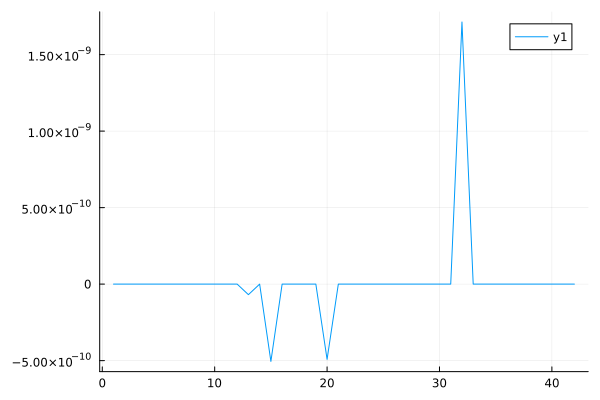

In [381]:
plot(all_utraj[1,410:451]*1e3/86400^2)

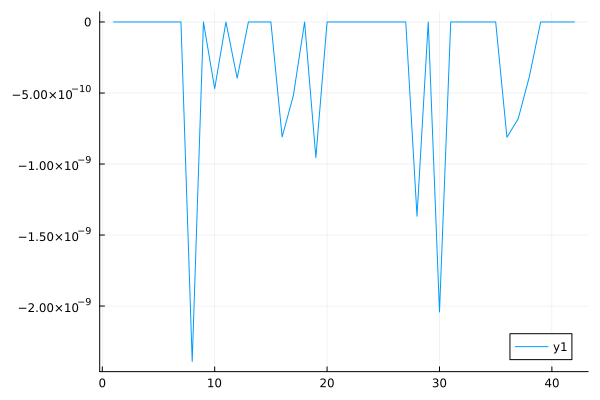

In [380]:
plot(all_utraj[2,410:451]*1e3/86400^2)

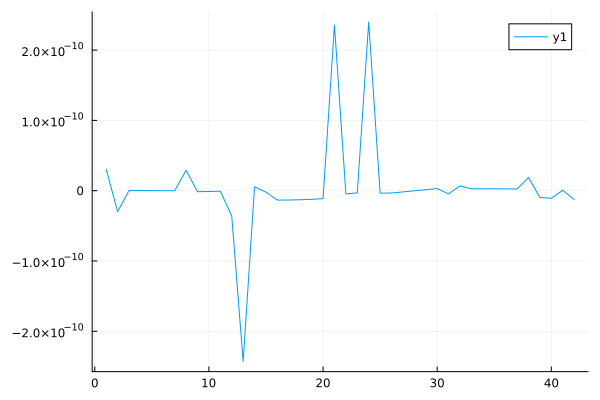

In [379]:
plot(all_utraj[3,410:451])

In [321]:
horizon 

41-element LinRange{Float64, Int64}:
 0.0, 0.371304, 0.742609, 1.11391, …, 13.7383, 14.1096, 14.4809, 14.8522

In [322]:
Δt

0.3713042889610444

In [323]:
days_range = range(0,409, 410)

days = collect(days_range)*Δt

410-element Vector{Float64}:
   0.0
   0.3713042889610444
   0.7426085779220888
   1.1139128668831333
   1.4852171558441776
   1.8565214448052219
   2.2278257337662666
   2.599130022727311
   2.970434311688355
   3.3417386006493994
   ⋮
 148.8930198733788
 149.26432416233985
 149.6356284513009
 150.00693274026193
 150.378237029223
 150.74954131818401
 151.12084560714507
 151.4921498961061
 151.86345418506716

In [324]:
days[41]

14.852171558441775

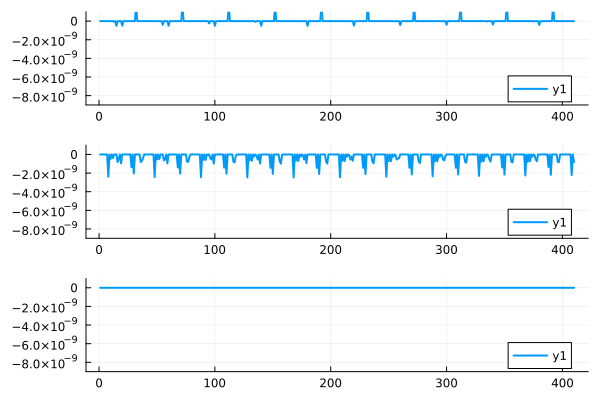

In [325]:
plot_range = (-9e-9, 1e-9)

plot1 = plot(all_utraj[1,410:819]*1e3/86400^2, linewidth = 2,ylim = plot_range,xlabel="")
plot2 = plot(all_utraj[2,410:819]*1e3/86400^2, linewidth = 2, ylim = plot_range)
plot3 = plot(all_utraj[3,410:819]*1e3/86400^2, linewidth=2, ylim = plot_range)


plot_layout = @layout [a;
                       b; 
                       c]

plot(plot1, plot2, plot3, layout=plot_layout)

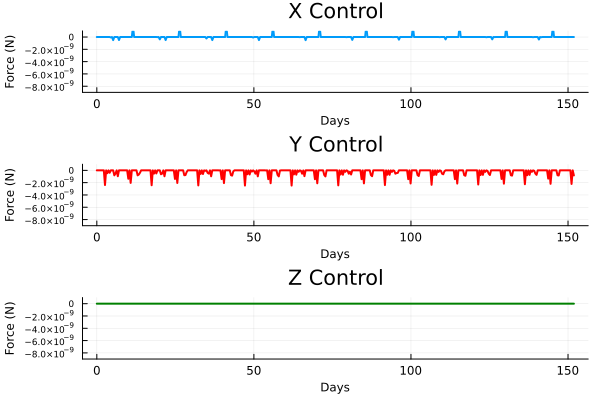

In [326]:
#this plots orbits 10-20

plot_range = (-9e-9, 1e-9)


plot1 = plot(days, all_utraj[1,410:819]*1e3/86400^2, linewidth = 2,ylim = plot_range, title= "X Control")
plot2 = plot(days, all_utraj[2,410:819]*1e3/86400^2, linewidth = 2, ylim = plot_range, title= "Y Control", linecolor="red")
plot3 = plot(days , all_utraj[3,410:819]*1e3/86400^2, linewidth=2, ylim = plot_range, title= "Z Control", linecolor="green")


plot_layout = @layout [a;
                       b; 
                       c]

control1020 = plot(plot1, plot2, plot3, layout=plot_layout, legend=false, xlabel="Days", xlabelfontsize=8, ylabel="Force (N)", ylabelfontsize=8, ytickfontsize = 6)

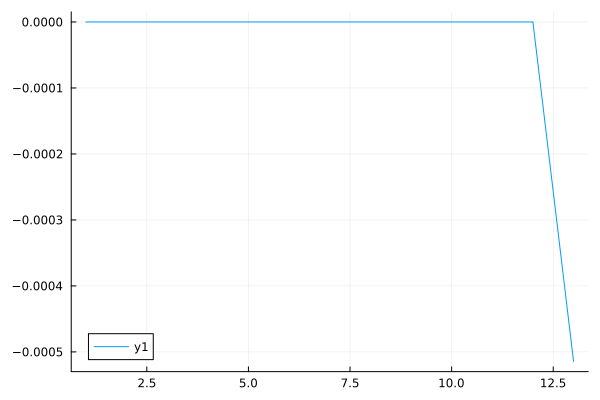

In [327]:
plot(all_utraj[1,410:422])

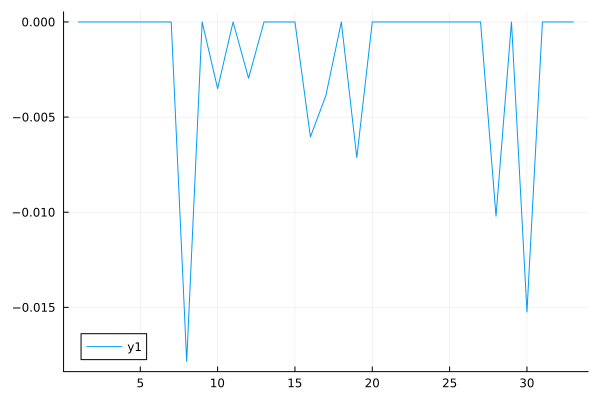

In [328]:
plot(all_utraj[2,410:442])

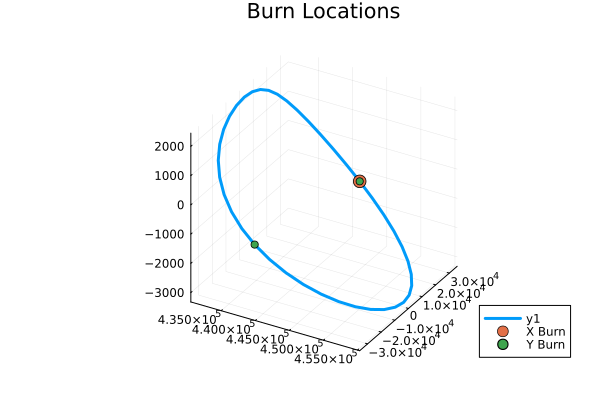

In [329]:
burn_locations = plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], linewidth = 3, title= "Burn Locations")
scatter!([reference_trajectory[1,12]],[reference_trajectory[2,12]],[reference_trajectory[3,12]], label="X Burn", markersize = 7)
scatter!([reference_trajectory[1,12], reference_trajectory[1,31]],[reference_trajectory[2,12], reference_trajectory[2,31]],[reference_trajectory[3,12], reference_trajectory[3,31]], label="Y Burn", markersize = 4)

In [330]:
#savefig( burn_locations, "burn_locations")

In [331]:
#savefig( control1020, "control1020")

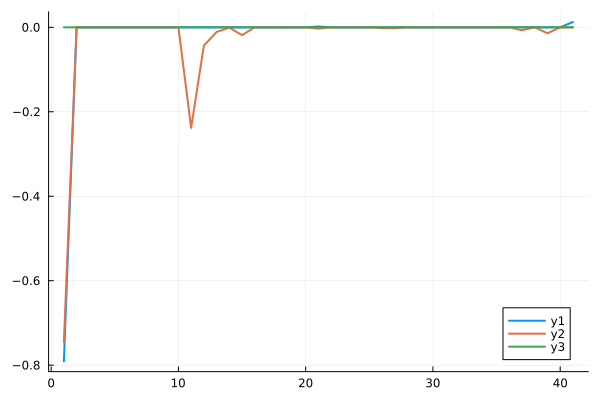

In [332]:
plot(all_utraj[1,1:41], linewidth = 2)
plot!(all_utraj[2,1:41], linewidth = 2)
plot!(all_utraj[3,1:41], linewidth=2)

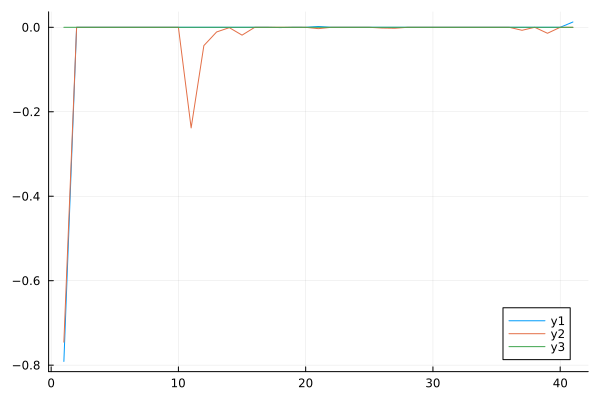

In [333]:
plot(all_utraj[1,1:41])
plot!(all_utraj[2,1:41])
plot!(all_utraj[3,1:41])

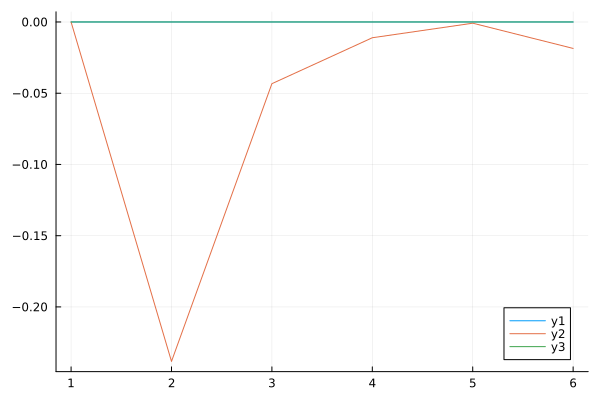

In [334]:
plot(all_utraj[1,10:15])
plot!(all_utraj[2,10:15])
plot!(all_utraj[3,10:15])

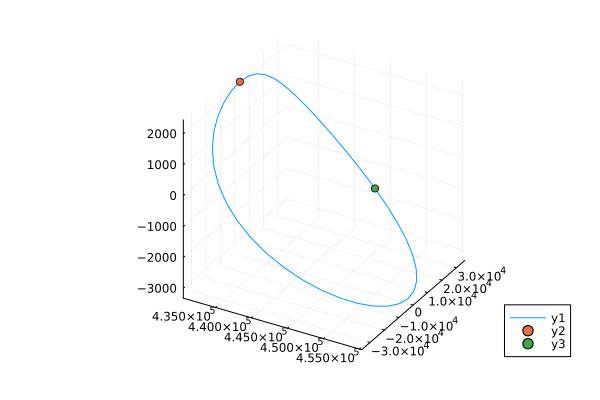

In [335]:
plot(all_xtraj[1,1:41], all_xtraj[2,1:41], all_xtraj[3,1:41])


scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]])
scatter!([all_xtraj[1,13]], [all_xtraj[2,13]], [all_xtraj[3,13]])

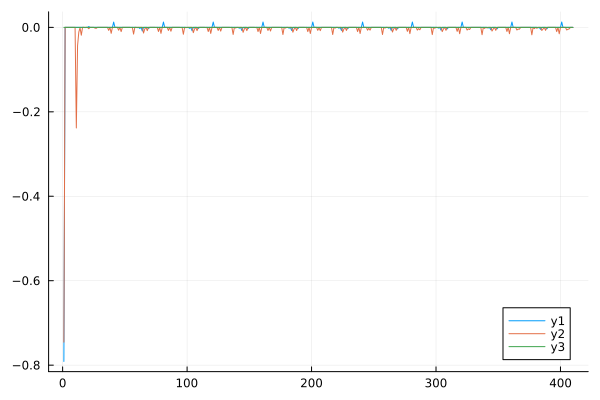

In [336]:
#this is for 5 orbits
plot(all_utraj[1,1:410])
plot!(all_utraj[2,1:410])
plot!(all_utraj[3,1:410])

In [337]:
# size(all_utraj)

In [339]:
one_orbit = all_utraj[:,41:80]

3×40 Matrix{Float64}:
 0.0125798     9.97045e-11   4.81177e-11  …  -1.66426e-12  -1.20901e-12
 4.39898e-12  -5.05298e-11  -9.97524e-11     -0.01418      -3.21344e-10
 2.02074e-11   9.56602e-12   9.99063e-12      2.5442e-13    2.56769e-12

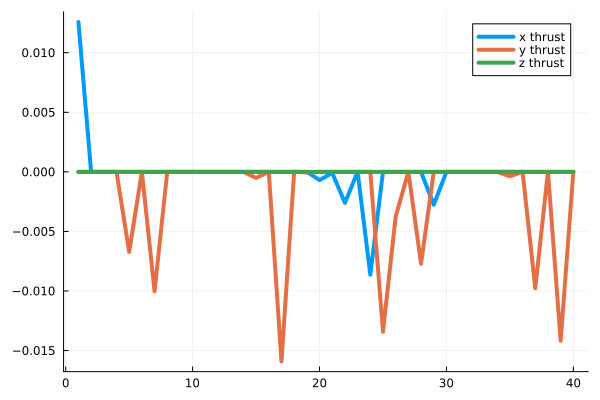

In [340]:
#the beginning thrust is to get it back on track since the initialization is off by 1e-3

plot(one_orbit[1,:], label="x thrust", linewidth=4)

plot!(one_orbit[2,:], label="y thrust", linewidth=4)

plot!(one_orbit[3,:], label="z thrust", linewidth=4)

In [341]:
#once we are at the orbit this is what it looks like
last_orbit = all_utraj[:,3961:end]

3×40 Matrix{Float64}:
  0.0125272     7.15637e-12   3.29254e-12  …  -3.38245e-13  -2.58154e-13
 -5.39895e-12  -8.32571e-12  -2.73637e-11     -0.0103385    -0.00799113
 -4.62306e-14   7.33936e-13   7.221e-13        8.52505e-14   1.91688e-12

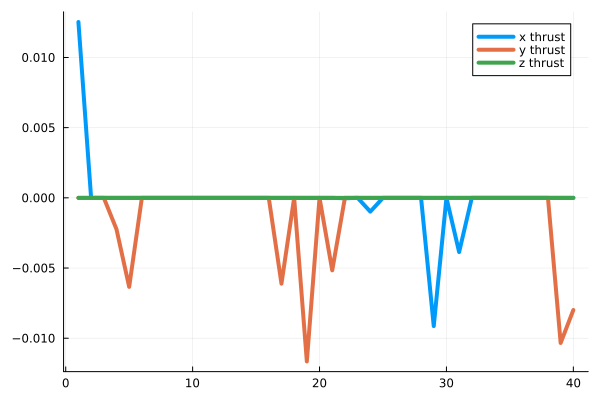

In [342]:
plot(last_orbit[1,:], label="x thrust", linewidth=4)

plot!(last_orbit[2,:], label="y thrust", linewidth=4)

plot!(last_orbit[3,:], label="z thrust", linewidth=4)

In [343]:
all_xtraj

6×4100 Matrix{Float64}:
     4.3125e5      4.31267e5      4.31339e5  …  431267.0    431250.0
     0.0        5775.2        11343.5            -5775.23       -0.0161854
  2286.77       2237.81        2094.64            2237.57     2286.53
     0.0         101.164        306.421           -101.367       0.00373324
 15649.1       15364.6        14545.8            15364.7     15649.0
     0.0        -262.02        -504.466      …     261.995      -0.00143153

In [344]:
all_utraj 

3×4000 Matrix{Float64}:
 -0.791216     -1.75337e-14  -7.77816e-15  …  -3.38245e-13  -2.58154e-13
 -0.74552      -9.09247e-14  -5.56664e-14     -0.0103385    -0.00799113
  3.36537e-12   2.09935e-15   2.41223e-15      8.52505e-14   1.91688e-12

In [345]:
norm(all_utraj[:,1])

1.0871170146205134

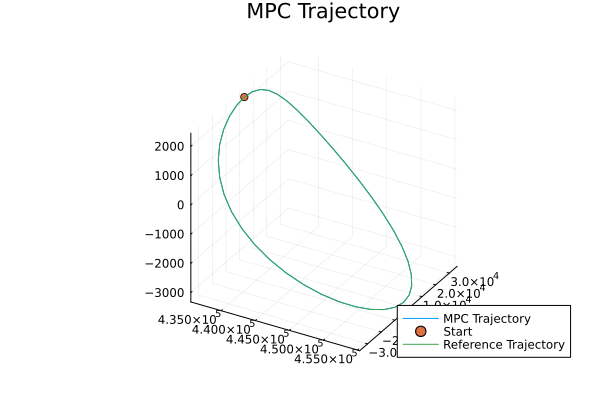

In [347]:
#plot the 100 orbits

plot(all_xtraj[1,:], all_xtraj[2,:], all_xtraj[3,:], label="MPC Trajectory", title="MPC Trajectory")

scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label = "Reference Trajectory")

In [348]:
all_xtraj 

6×4100 Matrix{Float64}:
     4.3125e5      4.31267e5      4.31339e5  …  431267.0    431250.0
     0.0        5775.2        11343.5            -5775.23       -0.0161854
  2286.77       2237.81        2094.64            2237.57     2286.53
     0.0         101.164        306.421           -101.367       0.00373324
 15649.1       15364.6        14545.8            15364.7     15649.0
     0.0        -262.02        -504.466      …     261.995      -0.00143153

In [349]:
all_xtraj

6×4100 Matrix{Float64}:
     4.3125e5      4.31267e5      4.31339e5  …  431267.0    431250.0
     0.0        5775.2        11343.5            -5775.23       -0.0161854
  2286.77       2237.81        2094.64            2237.57     2286.53
     0.0         101.164        306.421           -101.367       0.00373324
 15649.1       15364.6        14545.8            15364.7     15649.0
     0.0        -262.02        -504.466      …     261.995      -0.00143153

In [350]:
all_xtraj[1:3,41]/L 

3-element Vector{Float64}:
  1.120129730727341
 -5.490443788451725e-8
  0.005939628963135709

In [351]:
all_xtraj[4:6,41]/V_ 

3-element Vector{Float64}:
 4.360946258435396e-8
 0.17677818174625953
 1.4835911643332655e-7

In [352]:
all_xtraj

6×4100 Matrix{Float64}:
     4.3125e5      4.31267e5      4.31339e5  …  431267.0    431250.0
     0.0        5775.2        11343.5            -5775.23       -0.0161854
  2286.77       2237.81        2094.64            2237.57     2286.53
     0.0         101.164        306.421           -101.367       0.00373324
 15649.1       15364.6        14545.8            15364.7     15649.0
     0.0        -262.02        -504.466      …     261.995      -0.00143153

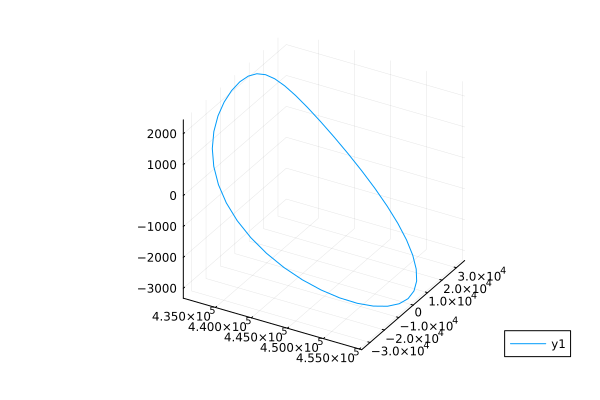

In [353]:
plot(all_xtraj[1, 1:41],all_xtraj[2, 1:41],all_xtraj[3, 1:41])

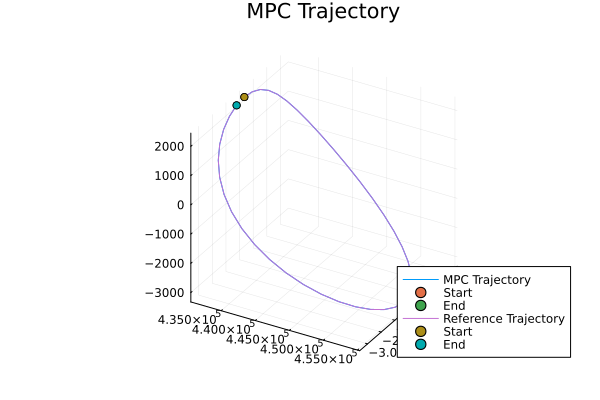

In [354]:
iter = 40

plot(all_xtraj[1,1:iter], all_xtraj[2,1:iter], all_xtraj[3,1:iter], label="MPC Trajectory", title="MPC Trajectory")
scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")
scatter!([all_xtraj[1,iter]], [all_xtraj[2,iter]], [all_xtraj[3,iter]], label="End")
plot!(reference_trajectory[1,1:iter], reference_trajectory[2,1:iter], reference_trajectory[3,1:iter], label = "Reference Trajectory")
scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]], label="Start")
scatter!([reference_trajectory[1,iter]], [reference_trajectory[2,iter]], [reference_trajectory[3,iter]], label="End")


In [355]:
#plot the final orbit
size(all_xtraj)

(6, 4100)

In [356]:
#i = 50
#plot(all_xtraj[1,40*(i-1)+1:40*i], all_xtraj[2,40*(i-1)+1:40*i], all_xtraj[3,40*(i-1)+1:40*i], label="MPC Trajectory", title="MPC Trajectory",lw=3)


#plot!(all_xtraj[1,41:80], all_xtraj[2,41:80], all_xtraj[3,41:80], label="MPC Trajectory", title="MPC Trajectory",lw=3)
#plot!(all_xtraj[1,81:120], all_xtraj[2,81:120], all_xtraj[3,81:120], label="MPC Trajectory", title="MPC Trajectory",lw=3)



#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3)


#plot(all_xtraj[1,41:80], all_xtraj[2,41:80], all_xtraj[3,41:80], label="MPC Trajectory", title="MPC Trajectory", lw=3)
#plot(all_xtraj[1,81:end], all_xtraj[2,81:end], all_xtraj[3,81:end], label="MPC Trajectory", title="MPC Trajectory", lw=3)

#scatter!([all_xtraj[1,1]],[all_xtraj[2,1]], [all_xtraj[3,1]], label="1")

#scatter!([all_xtraj[1,40]],[all_xtraj[2,40]], [all_xtraj[3,40]], label="40")

#scatter!([all_xtraj[1,41]],[all_xtraj[2,41]], [all_xtraj[3,41]], label="41")

#scatter!([all_xtraj[1,81]],[all_xtraj[2,81]], [all_xtraj[3,81]], label="80")

In [357]:
#plot(optimal_u[1,:].*acceleration_scale)

In [358]:
#plot(optimal_u[2,:])

In [359]:
#plot(optimal_u[3,:])

In [360]:
#acceleration_scale

In [361]:
#scaled_control.*acceleration_scale

In [362]:
#all_utraj

In [363]:
all_xtraj[:,21]

6-element Vector{Float64}:
 454619.6199465121
     -0.0008590702582710473
  -3158.0260086896055
     -0.003164237587993828
 -13831.16805848712
     -0.009254749853463086

In [364]:
all_xtraj[:,22]

6-element Vector{Float64}:
 454408.3528381426
  -5115.626328713298
  -3131.959079701995
  -1134.1460615743329
 -13670.155857972044
    140.25536972782996

In [365]:
all_utraj

3×4000 Matrix{Float64}:
 -0.791216     -1.75337e-14  -7.77816e-15  …  -3.38245e-13  -2.58154e-13
 -0.74552      -9.09247e-14  -5.56664e-14     -0.0103385    -0.00799113
  3.36537e-12   2.09935e-15   2.41223e-15      8.52505e-14   1.91688e-12

In [366]:
#this is already in units of km/(days)^2
scaled_control = all_utraj

3×4000 Matrix{Float64}:
 -0.791216     -1.75337e-14  -7.77816e-15  …  -3.38245e-13  -2.58154e-13
 -0.74552      -9.09247e-14  -5.56664e-14     -0.0103385    -0.00799113
  3.36537e-12   2.09935e-15   2.41223e-15      8.52505e-14   1.91688e-12

In [367]:
all_Δxtraj[:,1]

6-element Vector{Float64}:
 0.3850000000093132
 0.0
 0.0
 0.0
 0.08852345449304266
 0.0

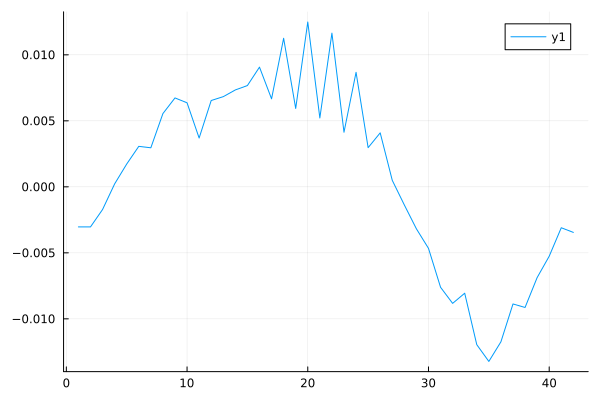

In [368]:
plot(all_Δxtraj[1,41:82])

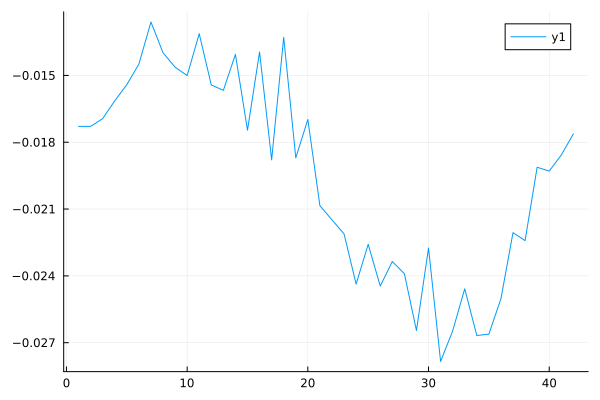

In [369]:
plot(all_Δxtraj[2,41:82])

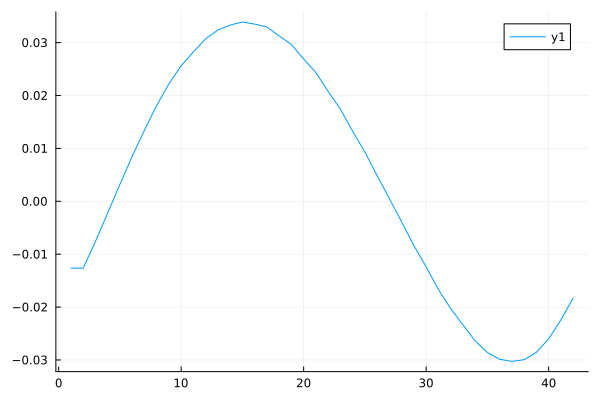

In [370]:
plot(all_Δxtraj[3,41:82])

In [372]:
#the Δt is in SI units (days)

In [374]:
#integrate over the timestep to get the velocity cost in km/day
x_cost = sum(abs.(scaled_control[1,:]))*(Δt)
y_cost = sum(abs.(scaled_control[2,:]))*(Δt)
z_cost = sum(abs.(scaled_control[3,:]))*(Δt)

2.3576857292081988e-8

In [375]:
x_cost

1.1849276547725471

In [376]:
25e-3*86400^2*Δt/86400

802.0172641558559

In [377]:
#velocity cost in m/s
#dividing by 86400 to get into seconds bc currently it is in days

#units are good (checked in simulation_test)
x_cost_ms = x_cost*(1e3/86400)
y_cost_ms = y_cost*(1e3/86400)
z_cost_ms = z_cost*(1e3/86400)

display(x_cost_ms)
display(y_cost_ms)
display(z_cost_ms)

0.013714440448756332

0.030509481389764653

2.728802927324304e-10

In [378]:
all_cost = x_cost_ms + y_cost_ms + z_cost_ms 

0.04422392211140128

In [ ]:
cost_per_rev = all_cost/orbit_num

In [ ]:
# #Exclude the first 10 timesteps to fix the injection error
# x_cost_good = sum(abs.(scaled_control[1,42:end]))*(Δt) *(1e3/86400)
# y_cost_good = sum(abs.(scaled_control[2,42:end]))*(Δt) *(1e3/86400)
# z_cost_good = sum(abs.(scaled_control[3,42:end]))*(Δt) *(1e3/86400)

# display(x_cost_good)
# display(y_cost_good)
# display(z_cost_good)

In [ ]:
# #cost for 95 revs
# all_cost_good = x_cost_good + y_cost_good + z_cost_good

In [ ]:
#final_mpc = reference_trajectory + optimal_x

In [ ]:
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")

In [ ]:
#initially
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")
#scatter!([final_mpc[1,1]], [final_mpc[2,1]],[final_mpc[3,1]], label= "Start Point")

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Trajectory")

In [ ]:
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")
#scatter!([final_mpc[1,1]], [final_mpc[2,1]], [final_mpc[3,1]], label= "Start Point")
#scatter!([final_mpc[1,end]], [final_mpc[2,end]], [final_mpc[3,end]], label= "End Point")

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Trajectory")

In [ ]:
#diff = final_mpc - reference_trajectory

In [ ]:
#plot(diff[1,:])
#plot!(diff[2,:])
#plot!(diff[3,:])

In [ ]:
plot(all_xtraj[1,:], all_xtraj[2,:])

In [ ]:
all_xtraj[:,end]

In [ ]:
all_optimal_x[:,:,end]

In [ ]:
dot(all_optimal_x[:,end,end], unstable_directions_2[:,21])    

In [ ]:
all_optimal_x

In [ ]:
end_state = all_xtraj[:,end]

end_state_sim = just_dynamics_integrate(end_state, 2.75*sol_t_final[end])


end_state_traj = get_state(end_state_sim)

In [ ]:
#testing
#end_state_sim = reference_trajectory[:,end]

In [ ]:
delta_end = end_state - reference_trajectory[:,end]

In [ ]:
#end_state_test = reference_trajectory[:,end] - delta_end

In [ ]:
#correct_end_state = end_state_test - reference_trajectory[:,end]

In [ ]:
#end_state_sim_correct = just_dynamics_integrate(end_state_test, 2.0*sol_t_final[end])


#end_state_traj_correct = get_state(end_state_sim_correct)

In [ ]:
deltaaa = xtraj_test[:,1:21] - all_xtraj[:,1:21]

In [ ]:
plot(deltaaa[6,:])

In [ ]:
half_test = all_xtraj[:,1:21] - reference_trajectory[:,1:21]

In [ ]:
constraint_check_test = zeros(21)
for i=1:21
    constraint_check_test[i] = dot(half_test[:,i], unstable_directions[:,i])

end

In [ ]:
constraint_check_test

In [ ]:
#check the constraint...
constraint_check = zeros(4100)
for k=1:100
    for i=1:41

        constraint_check[41*(k-1)+i] = dot(unstable_directions[:,i], all_Δxtraj[:, 41*(k-1)+i]) #> 0 

    end
end

In [ ]:
constraint_check[1600:1625]

In [ ]:
plot(constraint_check.>0)

In [ ]:
constraint_check[1:15]

In [ ]:
0.77 * 1e3/86400

In [ ]:
constraint_check[50:75]

In [ ]:
#going to check what happens if I simulate the 4000 controls on the scaled model
all_utraj

In [ ]:
xtraj_test = integrate_oneperiod(all_xtraj[:,1], all_utraj[:,1:40])

In [ ]:
Δt/time_scale

In [ ]:
norm(xtraj_test[1:3,end]- xtraj_test[1:3,1])/L

In [ ]:
plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

In [ ]:
unstable_directions[:,end]


#for the negative manifold, the final state is satisfying the constraint and that's why it goes to the 
#left 

#however, for the positive manifold, it is satisfying the negative manifold constraint...

In [ ]:
dot(delta_end, unstable_directions[:,end])

In [ ]:
# #check this constraint 
# #works with pi/5 too 

# c_test = unstable_directions[:,end]/tan(pi/6)
# #c_test = unstable_directions[:,end]/tan((pi/2) - deg2rad(60))

# manifold_constraint_test = norm(delta_end) - c_test'*(delta_end)

# manifold_constraint_test
# #push!(cons, manifold_constraint <= 0)

In [ ]:
#angle away from the unstable manifold
dot(unstable_directions[:,end], delta_end)*norm(delta_end)*180/pi

In [ ]:
#escapes on the right for positive unstable direction!
plot(end_state_traj[1,:], end_state_traj[2,:])

scatter!([end_state_traj[1,1]], [end_state_traj[2,1]])

In [ ]:
#plot(end_state_traj_correct[1,:], end_state_traj_correct[2,:])

#goes to the right when it is in the positive manifold direction. hypothesis is true. however, 
#the solver is giving solutions that does not satisfy this constraint. need to figure out why...

In [ ]:
#needs to be a super small perturbation in order to stay stable

forward_rollout = zeros(6, N_period)

#forward_rollout[:,1] = [1e-3, 0, 0, 0, 1e-6,0]


forward_rollout[:,1] = [1e-9, 0, 0, 0, 1e-9, 0]

for i=1:N_period-1
   
    #diverges with no control 
    #forward_rollout[:,i+1] = all_Ad[:,:,i]*forward_rollout[:,i]
    
    #with disturbances it just blows up
    forward_rollout[:,i+1] = all_Ad[:,:,i]*forward_rollout[:,i] #+ randn(6)*1e-4
    
end
    

In [ ]:
reference_trajectory

In [ ]:
nocontrol = forward_rollout + reference_trajectory

In [ ]:
plot(nocontrol[1,:], nocontrol[2,:], nocontrol[3,:], lw=3, label="No Control")
plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3, label="Reference Trajectory")
scatter!([nocontrol[1,1]], [nocontrol[2,1]], [nocontrol[3,1]], label="No Control Start")
scatter!([nocontrol[1,end]], [nocontrol[2,end]],[nocontrol[3,end]], label="No Control End")

In [ ]:
# plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], lw=3, label="MPC Control")
# plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3, label="Reference Trajectory")
# scatter!([final_mpc[1,1]], [final_mpc[2,1]], [final_mpc[3,1]], label="No Control Start")
# scatter!([final_mpc[1,end]], [final_mpc[2,end]], [final_mpc[3,end]],  label="No Control End", aspectratio = true)

In [ ]:
position_tube_norm = zeros(N_period*orbit_num)

velocity_tube_norm = zeros(N_period*orbit_num)

In [ ]:
orbit_num

In [ ]:
svd(V[:,:,1]).S

In [ ]:
for i=1:N_period*orbit_num
   
    position_tube_norm[i]= norm(all_Δxtraj[1:3,i])
    
    velocity_tube_norm[i]= norm(all_Δxtraj[4:6,i])
    
end

In [ ]:
ctg_constraint = zeros(6, N_period)
dist_from_center = zeros(6, N_period)

In [ ]:
(ones(6).*0.1)./eigen(V[:,:,1]).values

In [ ]:
test_v = (ones(6).*0.1)./eigen(V[:,:,1]).vectors

In [ ]:
test_v * [1,1,1,0,0,0]

In [ ]:
V

In [ ]:
for i= 1:N_period

    e_decomp = eigen(V[:,:,i])

    #inverse same as transpose in this case
    y = inv(e_decomp.vectors) * all_Δxtraj[:,i]

    dist_from_center[:,i] = y

    ctg_constraint[:,i] = sqrt.(1e-3 .*ones(6)./e_decomp.values)


end

    

In [ ]:
ctg_constraint


In [ ]:
dist_from_center

In [ ]:
all_Δxtraj[:,1]'*V[:,:,1]*all_Δxtraj[:,1]

In [ ]:
dist_from_center[1,:]*L

In [ ]:
plot(dist_from_center[1,:], label="x")
plot!(ctg_constraint[1,:], label="x axis constraint")

In [ ]:
plot(dist_from_center[2,:], label="y")
plot!(ctg_constraint[2,:], label="y axis constraint")

In [ ]:
plot(dist_from_center[3,:], label="z")
plot!(ctg_constraint[3,:], label="z axis constraint")

In [ ]:
plot(dist_from_center[4,:], label="vx")
plot!(ctg_constraint[4,:], label="vx axis constraint")

In [ ]:
plot(dist_from_center[5,:], label="vy")
plot!(ctg_constraint[5,:], label="vy axis constraint")

In [ ]:
plot(dist_from_center[6,:], label="vz")
plot!(ctg_constraint[6,:], label="vz axis constraint")

In [ ]:
all_Δxtraj[:,1]

In [ ]:
V[:,:,1]

In [ ]:
#test.vectors*diagm(test.values)*test.vectors'

In [ ]:
#inv(test.vectors)

In [ ]:
#test.vectors'

In [ ]:
# #finding the magnitude of the principle axes of the ellipsoid
# magnitude_principle_axes = zeros(6, N_period)


# for i=1:N_period
    
#     magnitude_principle_axes[:,i] = svd(V[:,:,i]).S
    
    
# end

In [ ]:
# plot(magnitude_principle_axes[1,:])
# plot!(magnitude_principle_axes[2,:])
# plot!(magnitude_principle_axes[3,:])

In [ ]:
# plot(magnitude_principle_axes[4,:])
# plot!(magnitude_principle_axes[5,:])
# plot!(magnitude_principle_axes[6,:])

In [ ]:
plot(all_Δxtraj[1,:])

plot!(all_Δxtraj[2,:])

plot!(all_Δxtraj[3,:])

In [ ]:
plot(all_Δxtraj[4,:])

plot!(all_Δxtraj[5,:])

plot!(all_Δxtraj[6,:])